In [418]:
import numpy as np
import math
from math import cos
from math import sin
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import csv
import os
import re
from tqdm import tqdm
import scipy
from scipy import ndimage
from scipy import stats
from scipy.interpolate import interp1d
from scipy.ndimage.interpolation import shift
#%matplotlib inline
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
#from moviepy.editor import *
#from PIL import Image
#from glob import glob
import h5py


In [33]:
## open foraging h5 files and make an index that has the filename (trial ID) and the condition
# trial id: condition
# 

In [34]:
Path_h5 = 'C:/Users/ashsm/Documents/Stanford/timing-analysis/h5_files/'

trial_names = []
for file in os.listdir(Path_h5):
    if "trial" in file:
        trial_names.append(file)

In [35]:
print(trial_names)

['trial-1-20220727-132336.h5', 'trial-1-20220729-164750.h5', 'trial-1-20220801-111140.h5', 'trial-1-20220801-115554.h5', 'trial-1-20220801-135317.h5', 'trial-1-20220805-101342.h5', 'trial-1-20220805-1223.h5', 'trial-1-20220805-122355.h5', 'trial-1-20220805-134118.h5', 'trial-1-20220805-203350.h5', 'trial-1-20220808-114417.h5', 'trial-1-20220808-140616.h5', 'trial-1-20220808-141459.h5', 'trial-1-20220808-153148.h5', 'trial-1-20220809-103810.h5', 'trial-1-20220809-125158.h5', 'trial-1-20220811-113314.h5', 'trial-1-20220811-134702.h5', 'trial-1-20220811-160843.h5', 'trial-1-20220815-104351.h5', 'trial-1-20220815-114713.h5', 'trial-1-20220815-130623.h5', 'trial-10-20220729-221651.h5', 'trial-10-20220805-125403.h5', 'trial-10-20220805-145037.h5', 'trial-10-20220808-131932.h5', 'trial-10-20220809-121552.h5', 'trial-10-20220811-193709.h5', 'trial-10-20220815-11402.h5', 'trial-10-20220815-114025.h5', 'trial-11-20220805-125614.h5', 'trial-11-20220805-145359.h5', 'trial-11-20220808-131958.h5', '

In [36]:
index_condition = {}
index_genotype = {}
for trial in trial_names:
    path = os.path.join(Path_h5, trial)
    with h5py.File(path, 'r') as hf: 
       ##get rid of trials that don't have data here
        if "x raw" in hf.keys() and hf['x raw'][()] is not None:
            if "condition" in hf.keys():
                condition = hf['condition'][()]  ##need this [()] to return as nparray instead of h5 obj
                #print(condition)
                index_condition[trial.strip(".h5")] = condition
            if 'genotype' in hf.keys():
                genotype = hf['genotype'][()]
                index_genotype[trial.strip(".h5")] = genotype
            if 'min off time (s)' in hf.keys():
                min_off = hf['min off time (s)'][()]
                #print(min_off)
                #check that min_off matches condition if min_off exists  
                if min_off in condition:
                    #print(hf['opto x'][()])
                    continue
                    #print('ok')

                else:
                    print(f"Issue: condition: {condition} does not match metadata {min_off} for trial: {trial}")
                    ##its ok if the conditions don't match for no opto because if 0 foodspots is selected then the min off doesn't matter
    #               ## annoyingly I don't store # foodspots in metadata (though I should)
                    #I can check based on opto if necessary
                    opto_x = hf['opto x'][()]
                    if len(opto_x) == 0:
                        print("OK-no opto")
                    else:
                        print("BIG PROBLEM ASHLEY")
                        print("condition does not match metadata and it is not 'no opto'")
                

Issue: condition: no opto (set to 0 foodspots) does not match metadata 20 for trial: trial-1-20220811-113314.h5
OK-no opto
Issue: condition: no opto (0 foodspots) does not match metadata 40 for trial: trial-1-20220815-114713.h5
OK-no opto
Issue: condition: no opto (set to 0 foodspots) does not match metadata 20 for trial: trial-2-20220811-114737.h5
OK-no opto
Issue: condition: no opto (0 foodspots) does not match metadata 40 for trial: trial-2-20220815-114845.h5
OK-no opto
Issue: condition: no opto (set to 0 foodspots) does not match metadata 20 for trial: trial-3-20220811-120952.h5
OK-no opto
Issue: condition: no opto (0 foodspots) does not match metadata 40 for trial: trial-3-20220815-114924.h5
OK-no opto
Issue: condition: no opto (set to 0 foodspots) does not match metadata 20 for trial: trial-4-20220811-121702.h5
OK-no opto
Issue: condition: no opto (0 foodspots) does not match metadata 40 for trial: trial-4-20220815-115607.h5
OK-no opto
Issue: condition: no opto (set to 0 foodspot

In [37]:
all_conditions = []
all_genotypes = []
for item in index_condition:
    #print(item)
    #print(index_dict.keys())
    #print(index_dict[item])
    all_conditions.append(index_condition[item])
    all_genotypes.append(index_genotype[item])  #this will get weird if there is a case that there is a condition specified but not a genoytype
individual_conditions = set(all_conditions) #get rid of duplicates
individual_genotypes = set(all_genotypes)
print(individual_conditions)
print(individual_genotypes)

{'40s laser opto 1s off', '40s off 1s on', '20s opto laser', '20s laser', '40s laser', 'no opto (set to 0 foodspots)', '20s opto no center req, light on for 1s', '20s laser opto 1s off', '40s off 1s on ', '20s laser opto', 'no opto (0 foodspots)', '40s opto laser'}
{'gr5a/+', 'ISOD1', 'gr5a/+chrimson/+', 'gr5a/+;chrimson/+'}


In [38]:
print(individual_conditions)
## essentally 3 conditions (20s, 40s, no opto)


{'40s laser opto 1s off', '40s off 1s on', '20s opto laser', '20s laser', '40s laser', 'no opto (set to 0 foodspots)', '20s opto no center req, light on for 1s', '20s laser opto 1s off', '40s off 1s on ', '20s laser opto', 'no opto (0 foodspots)', '40s opto laser'}


In [39]:
###turn this into a dictionary later for faster lookup in rest of code

##sort the index lists to get specific lists of trials to look at
trials_40s = []
trials_20s = []
trials_no_opto = []
for trial in index_condition:
    if "40s" in index_condition[trial]:
        #then it is 40s
        trials_40s.append(trial)
    elif "20s" in index_condition[trial]:
        #then it is 40s
        trials_20s.append(trial)
    elif "no opto" in index_condition[trial]:
        #then it is 40s
        trials_no_opto.append(trial)
    
trials_ISOD1 = []
trials_gr5a_control = [] # only gr5a
trials_gr5a_chrimson = []
for trial in index_genotype:
    if 'gr5a' in index_genotype[trial] and 'chrimson' in index_genotype[trial]:
        trials_gr5a_chrimson.append(trial)
    elif 'gr5a/+' in index_genotype[trial] and 'chrimson' not in index_genotype[trial]:
        trials_gr5a_control.append(trial)
    elif 'ISOD1' in index_genotype[trial]:
        trials_ISOD1.append(trial)

##get specific lists of trials for different conditions
##Really feels like there should be a better way to do this...

print('40-', len(trials_40s))
print('20-', len(trials_20s))
print('no opto-', len(trials_no_opto))
print('iso-', len(trials_ISOD1))
print('gr control-', len(trials_gr5a_control))
print('exp gen-', len(trials_gr5a_chrimson))

trials_iso_40 = []
trials_iso_20 = []
trials_iso_none = []
trials_exp_40 = []
trials_exp_20 = []
trials_exp_none = []
trials_gr_control_40 = []
trials_gr_control_20 = []
trials_gr_control_none = []
##merge iso and gr
trials_control_40 = []
trials_control_20 = []
trials_control_none = []

for trial in index_genotype:
    if trial in trials_ISOD1:
        if trial in trials_40s:
            trials_iso_40.append(trial)
            trials_control_40.append(trial)
        elif trial in trials_20s:
            trials_iso_20.append(trial)
            trials_control_20.append(trial)
        elif trial in trials_no_opto:
            trials_iso_none.append(trial)
            trials_control_none.append(trial)
    elif trial in trials_gr5a_control:
        if trial in trials_40s:
            trials_gr_control_40.append(trial)
            trials_control_40.append(trial)
        elif trial in trials_20s:
            trials_gr_control_20.append(trial)
            trials_control_20.append(trial)
        elif trial in trials_no_opto:
            trials_gr_control_none.append(trial)
            trials_control_none.append(trial)
    elif trial in trials_gr5a_chrimson:
        if trial in trials_40s:
            trials_exp_40.append(trial)
        elif trial in trials_20s:
            trials_exp_20.append(trial)
        elif trial in trials_no_opto:
            trials_exp_none.append(trial)

print('iso 40-', len(trials_iso_40))
print('iso 20-', len(trials_iso_20))
print('iso none-', len(trials_iso_none))
print('exp 20-', len(trials_exp_20))
print('exp 40-', len(trials_exp_40))
print('exp none-', len(trials_exp_none))
print('all control 40-', len(trials_control_40))
print('all control 20-', len(trials_control_20))
print('all control none-', len(trials_control_none))

40- 68
20- 51
no opto- 11
iso- 30
gr control- 40
exp gen- 60
iso 40- 22
iso 20- 8
iso none- 0
exp 20- 18
exp 40- 36
exp none- 6
all control 40- 32
all control 20- 33
all control none- 5


In [40]:
##open h5 files and plot
#consider also presorting no data expts

## places with trials for plotting 
# trials_exp_40
# trials_exp_20
# trials_exp_none
# ##merge iso and gr
# trials_control_40
# trials_control_20
# trials_control_none

In [41]:
# #print potential keys to use for functions
# with h5py.File(Path, 'a') as f:
#     a = list(f.keys())
#     print(a)
#     print(f['food radius (mm)'][()])

# #testing functions 

# trial = trials_control_20[0]
# Path = os.path.join(Path_h5, trial + '.h5')
# total_time_in_foodspot, min_distance, foodspot_avg_dist, total_foodspots = get_foodspot_parameters(Path)
# print(total_time_in_foodspot)


In [75]:
## get number of foodspots
# get_total_foodspots
num_foodspots_20c = []
for trial in trials_control_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    num_foodspots_20c.append(get_total_foodspots(Path, 'y'))
num_foodspots_20e = []
for trial in trials_exp_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    num_foodspots_20e.append(get_total_foodspots(Path, 'y'))
num_foodspots_40c = []
for trial in trials_control_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    num_foodspots_40c.append(get_total_foodspots(Path, 'y'))
num_foodspots_40e = []
for trial in trials_exp_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    num_foodspots_40e.append(get_total_foodspots(Path, 'y'))

#get_total_time_in_foodspots
mean_time_foodspots_20c = []
for trial in trials_control_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    each_time_foodspots = get_total_time_in_foodspots(Path, 'y')
    print(each_time_foodspots)
    if each_time_foodspots is not None and len(each_time_foodspots) > 1:
        mean_time_foodspots_20c.append(np.mean(each_time_foodspots))
mean_time_foodspots_20e = []
for trial in trials_exp_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    each_time_foodspots = get_total_time_in_foodspots(Path, 'y')
    if each_time_foodspots is not None and len(each_time_foodspots) > 1:
        mean_time_foodspots_20e.append(np.mean(each_time_foodspots))
mean_time_foodspots_40c = []
for trial in trials_control_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    each_time_foodspots = get_total_time_in_foodspots(Path, 'y')
    if each_time_foodspots is not None and len(each_time_foodspots) > 1:
        mean_time_foodspots_40c.append(np.mean(each_time_foodspots))
mean_time_foodspots_40e = []
for trial in trials_exp_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    each_time_foodspots = get_total_time_in_foodspots(Path, 'y')
    if each_time_foodspots is not None and len(each_time_foodspots) > 1:
        mean_time_foodspots_40e.append(np.mean(each_time_foodspots))
                    
                                                          

[ 5.53  3.38  4.49 23.54  4.66  2.3   3.98  5.5   1.32  1.66  3.22  4.18
  1.12  1.25 18.61  2.49  2.34]
[35.17  1.06  1.08 13.15  0.4  17.48]
[ 7.5   4.68  8.18 30.73 38.63  4.79]
None
None
None
None
None
None
None
[1094.72   16.04   13.67   31.66   22.67    2.98   19.49    7.75   36.21
    9.2     6.86   33.72   26.2    10.36   23.02   35.14    6.03   11.11
   23.55    7.06    6.02   25.63    9.28   12.24   24.8    38.2     6.1
    7.53   13.61   34.45   25.64   19.35   39.6    10.97   25.98   47.1
   11.41   44.02   35.96   24.29    4.08    5.  ]
[22.44 21.45  6.17  5.28 15.76  7.1   9.34  3.47  1.22  0.98  4.09 55.46
  6.66 15.53  3.31  0.91]
None
[19.79  9.65  3.29 23.56 10.38  9.73 71.53 37.83  3.85  4.62  3.24]
[ 2.83 11.11  3.95]
[ 1.92  9.6  11.42]
[ 4.6  41.77 11.57 91.04  4.   66.51 27.12  0.33]
[ 1.66  1.5   8.07 15.87  3.19  5.96]
[1.31 1.03 5.14 4.7  1.37]
None
None
[ 0.85  1.79  0.82  1.08  5.36  1.53  1.82 16.01  0.71  3.21  0.92  1.14
  0.79  0.99]
None
[ 3.41  6.58 18

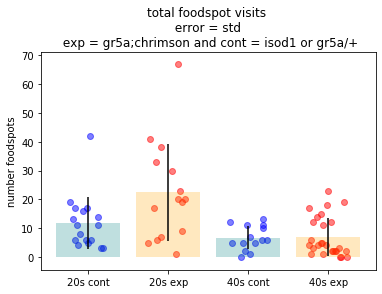

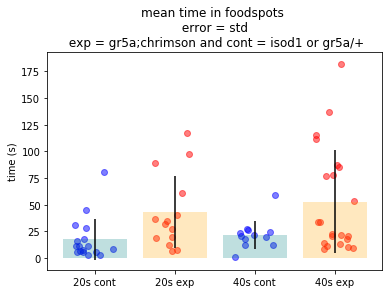

In [76]:
##plot foodspot parameters
##foodspot number
scatter_plot_conditions(num_foodspots_20c, num_foodspots_20e, num_foodspots_40c, num_foodspots_40e) 
bar_plot_conditions(num_foodspots_20c, num_foodspots_20e, num_foodspots_40c, num_foodspots_40e) 
plt.title('total foodspot visits \n error = std \n exp = gr5a;chrimson and cont = isod1 or gr5a/+')
plt.ylabel('number foodspots')
x = [0,1,2,3]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.show()



##plot foodspot mean time
scatter_plot_conditions(mean_time_foodspots_20c, mean_time_foodspots_20e, mean_time_foodspots_40c, mean_time_foodspots_40e) 
bar_plot_conditions(mean_time_foodspots_20c, mean_time_foodspots_20e, mean_time_foodspots_40c, mean_time_foodspots_40e) 
plt.title('mean time in foodspots \n error = std \n exp = gr5a;chrimson and cont = isod1 or gr5a/+')
plt.ylabel('time (s)')
x = [0,1,2,3,]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.show()

In [ ]:
# ## getting foodspot data and plotting total time in foodspot
# #rewrite this with new smaller functions 

# all_control_spots_20 = []
# all_control_num_foodspots_20 = []
# for trial in trials_control_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     total_time_in_foodspot, b, c, total_foodspots = get_foodspot_parameters(Path, quiet = 'y')
#     if total_foodspots is not None:
#         all_control_num_foodspots_20.append(total_foodspots)
#     if total_time_in_foodspot is not None and len(total_time_in_foodspot) > 1: #req more than one foodspot
#         jitter = np.random.rand(1)/2
#         plt.scatter(jitter - .25, np.mean(total_time_in_foodspot), color = 'blue', alpha = .5)
#         all_control_spots_20.append(np.mean(total_time_in_foodspot))
# all_exp_spots_20 = []
# all_exp_num_foodspots_20 = []
# for trial in trials_exp_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     total_time_in_foodspot, b, c, total_foodspots = get_foodspot_parameters(Path, quiet = 'y')
#     if total_foodspots is not None:
#         all_exp_num_foodspots_20.append(total_foodspots)
#     if total_time_in_foodspot is not None and len(total_time_in_foodspot) > 1:
#         jitter = np.random.rand(1)/2
#         plt.scatter(jitter + .75, np.mean(total_time_in_foodspot), color = 'red', alpha = .5)
#         all_exp_spots_20.append(np.mean(total_time_in_foodspot))
# all_control_spots_40 = []
# all_control_num_foodspots_40 = []
# for trial in trials_control_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     total_time_in_foodspot, b, c, total_foodspots = get_foodspot_parameters(Path, quiet = 'y')
#     if total_foodspots is not None:
#         all_control_num_foodspots_40.append(total_foodspots)
#     if total_time_in_foodspot is not None and len(total_time_in_foodspot) > 1: #req more than one foodspot
#         jitter = np.random.rand(1)/2
#         plt.scatter(jitter + 1.75, np.mean(total_time_in_foodspot), color = 'blue', alpha = .5)
#         all_control_spots_40.append(np.mean(total_time_in_foodspot))
# all_exp_spots_40 = []
# all_exp_num_foodspots_40 = []
# for trial in trials_exp_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     total_time_in_foodspot, b, c, total_foodspots = get_foodspot_parameters(Path, quiet = 'y')
#     if total_foodspots is not None:
#         all_exp_num_foodspots_40.append(total_foodspots)
#     if total_time_in_foodspot is not None and len(total_time_in_foodspot) > 1:
#         jitter = np.random.rand(1)/2
#         plt.scatter(jitter + 2.75, np.mean(total_time_in_foodspot), color = 'red', alpha = .5)
#         all_exp_spots_40.append(np.mean(total_time_in_foodspot))
# plt.bar(0, np.mean(all_control_spots_20), yerr = np.std(all_control_spots_20), alpha = .25, color = 'teal')
# plt.bar(1, np.mean(all_exp_spots_20), yerr = np.std(all_exp_spots_20), alpha = .25, color = 'orange')
# plt.bar(2, np.mean(all_control_spots_40), yerr = np.std(all_control_spots_40), alpha = .25, color = 'teal')
# plt.bar(3, np.mean(all_exp_spots_40), yerr = np.std(all_exp_spots_40), alpha = .25, color = 'orange')
# #plt.ylim(0,250)
# plt.title("total time in foodspots \n error = std \n more than one foodspot visit required")
# plt.ylabel('time (s)')
# x = [0,1,2,3]
# my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
# plt.xticks(x, my_xticks)

# plt.show()
    

In [ ]:
##average time in foodspots plot


In [77]:
## get average experiment length for each condition

all_exp_length_20c = []
for trial in trials_control_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_20c.append(experiment_length)
    
all_exp_length_20e = []
for trial in trials_exp_20:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_20e.append(experiment_length)
    
all_exp_length_40c = []
for trial in trials_control_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_40c.append(experiment_length)
    
all_exp_length_40e = []
for trial in trials_exp_40:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_40e.append(experiment_length)

all_exp_length_0c = []
for trial in trials_control_none:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_0c.append(experiment_length)
    
all_exp_length_0e = []
for trial in trials_exp_none:
    Path = os.path.join(Path_h5, trial + '.h5')
    experiment_length = get_experiment_length(Path, quiet = 'y')
    all_exp_length_0e.append(experiment_length)



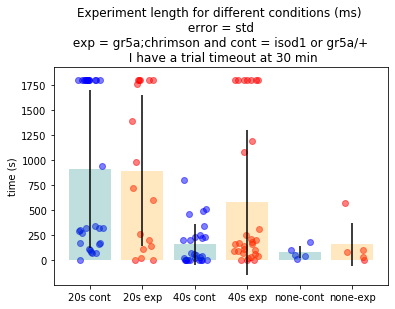

In [78]:
##plot experiment lengths
scatter_plot_conditions(all_exp_length_20c, all_exp_length_20e, all_exp_length_40c, all_exp_length_40e, all_exp_length_0c, all_exp_length_0e)
bar_plot_conditions(all_exp_length_20c, all_exp_length_20e, all_exp_length_40c, all_exp_length_40e, all_exp_length_0c, all_exp_length_0e)
plt.title('Experiment length for different conditions (ms) \n error = std \n exp = gr5a;chrimson and cont = isod1 or gr5a/+ \n I have a trial timeout at 30 min')
plt.ylabel('time (s)')
x = [0,1,2,3,4,5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'none-cont', 'none-exp'] 
plt.xticks(x, my_xticks)
plt.show()

In [147]:
## plot number foodspots/experiment length
##foodspot number
all_exp_length_20c = np.array(all_exp_length_20c)
num_foodspots_20c = np.array(num_foodspots_20c)
all_exp_length_20e = np.array(all_exp_length_20e)
num_foodspots_20e = np.array(num_foodspots_20e)
all_exp_length_40c = np.array(all_exp_length_40c)
num_foodspots_40c = np.array(num_foodspots_40c)
all_exp_length_40e = np.array(all_exp_length_40e)
num_foodspots_40e = np.array(num_foodspots_40e)

mask_20c = num_foodspots_20c != None
mask_20e = num_foodspots_20e != None
mask_40c = num_foodspots_40c != None
mask_40e = num_foodspots_40e != None

#print(all_exp_length_20c)

scatter_plot_conditions(num_foodspots_20c[mask_20c]/all_exp_length_20c[mask_20c], 
                        num_foodspots_20e[mask_20e]/all_exp_length_20e[mask_20e],
                       num_foodspots_40c[mask_40c]/all_exp_length_40c[mask_40c],
                       num_foodspots_40e[mask_40e]/all_exp_length_40e[mask_40e]) 
bar_plot_conditions(num_foodspots_20c[mask_20c]/all_exp_length_20c[mask_20c], 
                        num_foodspots_20e[mask_20e]/all_exp_length_20e[mask_20e],
                       num_foodspots_40c[mask_40c]/all_exp_length_40c[mask_40c],
                       num_foodspots_40e[mask_40e]/all_exp_length_40e[mask_40e]) 
plt.title('total foodspot visits normalized by experiment length \n error = stderror \n exp = gr5a;chrimson and cont = isod1 or gr5a/+')
plt.ylabel('number foodspots/experiment length')
x = [0,1,2,3]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 19 but corresponding boolean dimension is 33

In [80]:
## count proportion experiments where fly timed out
conditions = [all_exp_length_20c, all_exp_length_20e, all_exp_length_40c, all_exp_length_40e, all_exp_length_0c, all_exp_length_0e]
for cond in conditions:
    cond = np.array(cond, dtype=np.float64)
    maxed_out =  len(cond[cond>1700])
    total = len(cond[cond != np.nan])
    proportion = maxed_out/total
    print(proportion)

0.3939393939393939
0.3333333333333333
0.0
0.19444444444444445
0.0
0.0


In [ ]:
# #plot total number of foodspots visited during expeirment

# #conditions = [all_control_num_foodspots_20, all_exp_num_foodspots_20, all_control_num_foodspots_40, all_exp_num_foodspots_40]
# scatter_plot_conditions(all_control_num_foodspots_20, all_exp_num_foodspots_20, all_control_num_foodspots_40, all_exp_num_foodspots_40)
# bar_plot_conditions(all_control_num_foodspots_20, all_exp_num_foodspots_20, all_control_num_foodspots_40, all_exp_num_foodspots_40)

# plt.ylabel('number foodspots')
# plt.title('Number of foodspots \n at least one foodspot visit required')
# x = [0,1,2,3]
# my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
# plt.xticks(x, my_xticks)
# plt.show()

# ##also plot the length of time of experiment...

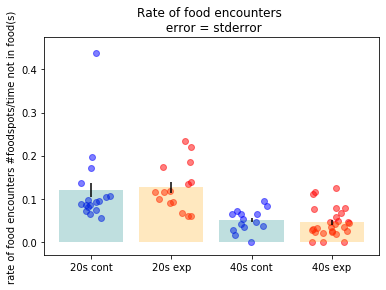

In [148]:
# get food encounter rate (number foodspots/time not in foodspot)

encounter_20c = run_on_all_trials(Path_h5, trials_control_20, get_food_encounter_rate)
encounter_20e = run_on_all_trials(Path_h5, trials_exp_20, get_food_encounter_rate)
encounter_40c = run_on_all_trials(Path_h5, trials_control_40, get_food_encounter_rate)
encounter_40e = run_on_all_trials(Path_h5, trials_exp_40, get_food_encounter_rate)
    

scatter_plot_conditions(encounter_20c, encounter_20e, encounter_40c, encounter_40e)
bar_plot_conditions(encounter_20c, encounter_20e, encounter_40c, encounter_40e)


plt.ylabel('rate of food encounters #foodspots/time not in food(s)')
x = [0,1,2,3]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.title("Rate of food encounters \n error = stderror")

plt.show()
##not sure why there are so many in control 20 that are in food the whole time...check the opto there. 

In [82]:
## fly speed in and out of foodspots

speed_40e = run_on_all_trials_mean(Path_h5, trials_exp_40, get_speed_during_food)
speed_20e = run_on_all_trials_mean(Path_h5, trials_exp_20, get_speed_during_food)
speed_40c = run_on_all_trials_mean(Path_h5, trials_control_40, get_speed_during_food)
speed_20c = run_on_all_trials_mean(Path_h5, trials_control_20, get_speed_during_food)

# speed_20c = []
# for trial in trials_control_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     speed_20c.append(np.nanmean(np.array(get_speed_during_food(Path, 'y')), dtype = np.float64))
    
# speed_20e = []
# for trial in trials_exp_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     speed_20e.append(np.nanmean(np.array(get_speed_during_food(Path, 'y')), dtype = np.float64))
    
# speed_40c = []
# for trial in trials_control_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     speed_40c.append(np.nanmean(np.array(get_speed_during_food(Path, 'y')), dtype = np.float64))
    
# speed_40e = []
# for trial in trials_exp_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     speed_40e.append(np.nanmean(np.array(get_speed_during_food(Path, 'y')), dtype = np.float64))
    
# speed_nonec = []
# for trial in trials_control_none:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and f['x raw'][()] is not None:
#             velocity = f['velocity'][()]
#             speed_nonec.append(np.mean(velocity))
            
# speed_nonee = []
# for trial in trials_exp_none:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and f['x raw'][()] is not None:
#             velocity = f['velocity'][()]
#             speed_nonee.append(np.mean(velocity))

C:\Python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
C:\Python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [83]:
# ## fly speed in and out of foodspots

# no_food_speed_20c = []
# for trial in trials_control_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     no_food_speed_20c.append(np.nanmean(np.array(get_speed_not_during_food(Path, 'y')), dtype = np.float64))
    
# no_food_speed_20e = []
# for trial in trials_exp_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     no_food_speed_20e.append(np.nanmean(np.array(get_speed_not_during_food(Path, 'y')), dtype = np.float64))
    
# no_food_speed_40c = []
# for trial in trials_control_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     no_food_speed_40c.append(np.nanmean(np.array(get_speed_not_during_food(Path, 'y')), dtype = np.float64))
    
# no_food_speed_40e = []
# for trial in trials_exp_40:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     no_food_speed_40e.append(np.nanmean(np.array(get_speed_not_during_food(Path, 'y')), dtype = np.float64))
    
# no_food_speed_nonec = []
# for trial in trials_control_none:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and f['x raw'][()] is not None:
#             velocity = f['velocity'][()]
#             no_food_speed_nonec.append(np.mean(velocity))
            
# no_food_speed_nonee = []
# for trial in trials_exp_none:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and f['x raw'][()] is not None:
#             velocity = f['velocity'][()]
#             no_food_speed_nonee.append(np.mean(velocity))

[2.8020991188283088e-05, 1.321178657369188e-05, 1.1966901780816822e-05, nan, nan, nan, nan, nan, nan, nan, 0.00013794449704167716, 1.1127177145349098e-05, nan, 9.621862995036928e-06, 2.7230846292671746e-05, 1.7237161931832433e-05, 9.784081705039435e-06, 2.0823503136238165e-05, 4.0053144315742744e-05, nan, nan, 5.277280544095982e-05, nan, 1.5249307615458987e-05, nan, nan, 1.8663576198394964e-05, 5.148458844716348e-06, nan, 1.4975494509898499e-05, 2.462214850259334e-06, nan, nan]


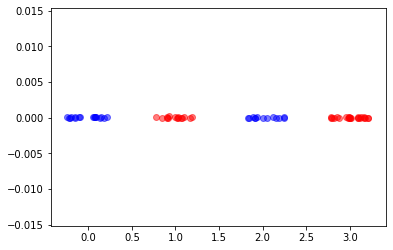

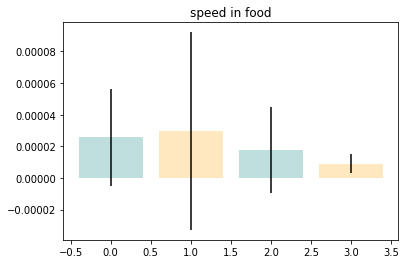

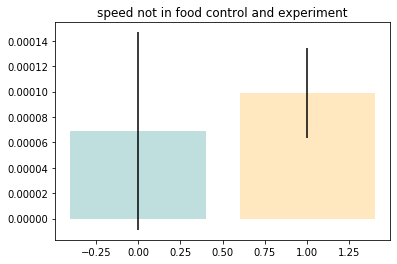

In [84]:
#speed in food
#print(speed_20c)
scatter_plot_conditions(speed_20c, speed_20e, speed_40c, speed_40e)
print(speed_20c)
plt.show()
bar_plot_conditions(speed_20c, speed_20e, speed_40c, speed_40e)
plt.title('speed in food')
plt.show()

bar_plot_conditions(speed_nonee, speed_nonec)
plt.title('speed not in food control and experiment')
plt.show()

[6.517765208585966e-05, 9.94789741469617e-05, 7.048241406006008e-05, nan, nan, nan, nan, nan, nan, nan, 0.0003718791546004118, 8.047588730398806e-05, nan, 0.00010915123112648077, 7.584461742036812e-05, 0.00012106263833569417, 6.166185306502454e-05, 8.040350125424446e-05, 7.540558467788911e-05, nan, nan, 0.00013137955282795476, nan, 6.889903024112604e-05, nan, nan, 9.478122493411564e-05, 0.00014383005084364232, nan, 8.485162317347222e-05, 7.835984363693924e-05, nan, nan]
0.00010665440198436662


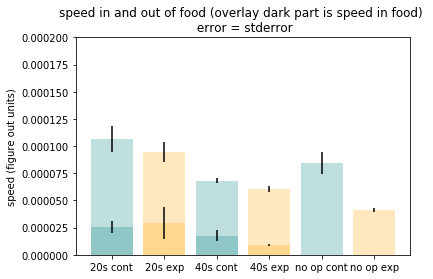

In [149]:
# ### speed not in food
# #run_on_all_trials(Path_h5, trials, function, quiet = 'y')
no_food_speed_40e = run_on_all_trials_mean(Path_h5, trials_exp_40, get_speed_not_during_food)
no_food_speed_20e = run_on_all_trials_mean(Path_h5, trials_exp_20, get_speed_not_during_food)
no_food_speed_40c = run_on_all_trials_mean(Path_h5, trials_control_40, get_speed_not_during_food)
no_food_speed_20c = run_on_all_trials_mean(Path_h5, trials_control_20, get_speed_not_during_food)
no_food_speed_nonec = run_on_all_trials_mean(Path_h5, trials_control_none, get_speed_not_during_food)
no_food_speed_nonee = run_on_all_trials_mean(Path_h5, trials_exp_none, get_speed_not_during_food)


## plot speed not in foodspots
print(no_food_speed_20c)
print(np.nanmean(no_food_speed_20c))
bar_plot_conditions((no_food_speed_20c), (no_food_speed_20e), (no_food_speed_40c), (no_food_speed_40e), no_food_speed_nonec, no_food_speed_nonee)
plt.ylabel('speed (figure out units)')
x = [0,1,2,3, 4, 5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'no op cont', 'no op exp'] 
plt.xticks(x, my_xticks)
plt.title("speed when not in food")
plt.ylim(0,.0002)
#plt.show()

bar_plot_conditions(speed_20c, speed_20e, speed_40c, speed_40e)
# plt.title('speed in food')
# x = [0,1,2,3, 4, 5]
# my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.ylim(0,.0002)

plt.title("speed in and out of food (overlay dark part is speed in food) \n error = stderror")
plt.show()

In [ ]:
int(1*60/.01)

In [112]:
# test = np.array([0,0,0,0,0,0,3,4,0,5,6,0,0,0,0,0,0,0,0,0,0,0,0, 4,5,4,5,4,5,0,4,5,0,0,4,5,7,10,1,1,1,0,0,0,0,0])
# print(test)
# plt.plot(test)

# zero_length = 4 ##will actually look for a length taht is two more than this
# min_velocity = 1
# zero_collect = []
# sleep_indices = []
# for index in range(len(test)):
#     if index != 0 and test[index] < min_velocity: #and test[index - 1] < min_velocity: #previous index also needs to be zero
#         zero_collect.append(index)
#         if index == (len(test) - 1) and len(zero_collect) >= zero_length: #if its the last index
#             print("long zeros--end of array", index)
#             sleep_indices.append((zero_collect[0], index))
#         elif len(zero_collect) > zero_length and test[index + 1] > min_velocity : #not last index and zero string is sufficiently long and next index is no longer zero
#             print("long zeros", index)
#             sleep_indices.append((zero_collect[0], index))
#             zero_collect = []
#     else:
#         zero_collect = []
        
# print(sleep_indices)
# zero_test = test[test<1]
# print(zero_test)

In [113]:
# #compare 0 and 3
# fly = 0
# trial = trials_control_20[fly]
# Path = os.path.join(Path_h5, trial + '.h5')
# with h5py.File(Path, 'a') as f:
#     velocity = f['velocity'][()]
#     print(max(abs(velocity)))
#     print(min(abs(velocity)))
#     print('mean',np.mean(abs(velocity)))
#     print(check_if_asleep (Path))
    
# fly = 3
# trial = trials_control_20[fly]
# Path = os.path.join(Path_h5, trial + '.h5')
# with h5py.File(Path, 'a') as f:
#     velocity = f['velocity'][()]
#     print(max(abs(velocity)))
#     print(min(abs(velocity)))
#     print(check_if_asleep (Path))

In [114]:
# active_fly_control_20 = []
# for trial in trials_control_20:
#     Path = os.path.join(Path_h5, trial + '.h5')
#     if check_if_asleep (Path) and len(check_if_asleep (Path)) > 0:
#         make_line_plots (Path, save = 'n', savePath = Path)
#         print(check_if_asleep(Path))
#         if (check_if_explorer(Path)) is False:
#             print("not explorer")
#         else:
#             print("sleepy explorer")
#     else:
#         active_fly_control_20.append(trial)
            

## filtering for active flies

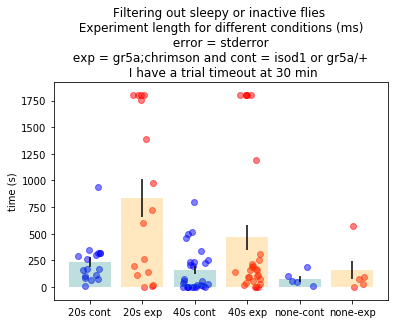

In [216]:
#is_active_fly(Path)

## get average experiment length for each condition

all_exp_length_20c = run_function(Path_h5, trials_control_20, get_experiment_length, is_active_fly)    
all_exp_length_20e = run_function(Path_h5, trials_exp_20, get_experiment_length, is_active_fly)    
all_exp_length_40c = run_function(Path_h5, trials_control_40, get_experiment_length, is_active_fly)
all_exp_length_40e = run_function(Path_h5, trials_exp_40, get_experiment_length, is_active_fly)
all_exp_length_0c = run_function(Path_h5, trials_control_none, get_experiment_length, is_active_fly)   
all_exp_length_0e = run_function(Path_h5, trials_exp_none, get_experiment_length, is_active_fly)



##plot experiment lengths
scatter_plot_conditions(all_exp_length_20c, all_exp_length_20e, all_exp_length_40c, all_exp_length_40e, all_exp_length_0c, all_exp_length_0e)
bar_plot_conditions(all_exp_length_20c, all_exp_length_20e, all_exp_length_40c, all_exp_length_40e, all_exp_length_0c, all_exp_length_0e)
plt.title('Filtering out sleepy or inactive flies \n Experiment length for different conditions (ms) \n error = stderror \n exp = gr5a;chrimson and cont = isod1 or gr5a/+ \n I have a trial timeout at 30 min')
plt.ylabel('time (s)')
x = [0,1,2,3,4,5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'none-cont', 'none-exp'] 
plt.xticks(x, my_xticks)
plt.show()

In [429]:
##one way anova
exp_l_20c = [fly for fly in all_exp_length_20c if fly is not None]
exp_l_20e = [fly for fly in all_exp_length_20e if fly is not None]
exp_l_40c = [fly for fly in all_exp_length_40c if fly is not None]
exp_l_40e = [fly for fly in all_exp_length_40e if fly is not None]
exp_l_0c = [fly for fly in all_exp_length_0c if fly is not None]
exp_l_0e = [fly for fly in all_exp_length_0e if fly is not None]
    

statistic, pvalue = scipy.stats.f_oneway(exp_l_20c, exp_l_20e, exp_l_40c, exp_l_40e, exp_l_0c, exp_l_0e)
print(statistic)
print(pvalue)

statistic, pvalue = scipy.stats.f_oneway(exp_l_20e, exp_l_40e, exp_l_0e)
print(statistic)
print(pvalue)

statistic, pvalue = scipy.stats.f_oneway(exp_l_40e, exp_l_40c)
print(statistic)
print(pvalue)


4.680071717182963
0.000755755406410384
2.4206319233058955
0.10035245843121682
5.074960335676925
0.02851995222809816


C:\Python37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


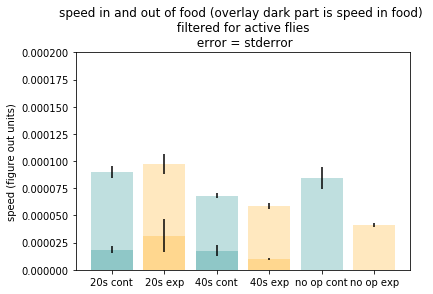

In [155]:
# ### speed not in food and filtered for active flies
# #run_on_all_trials(Path_h5, trials, function, quiet = 'y')
f_no_food_speed_40e = run_on_all_trials_mean(Path_h5, trials_exp_40, get_speed_not_during_food, is_active_fly)
f_no_food_speed_20e = run_on_all_trials_mean(Path_h5, trials_exp_20, get_speed_not_during_food, is_active_fly)
f_no_food_speed_40c = run_on_all_trials_mean(Path_h5, trials_control_40, get_speed_not_during_food, is_active_fly)
f_no_food_speed_20c = run_on_all_trials_mean(Path_h5, trials_control_20, get_speed_not_during_food, is_active_fly)
f_no_food_speed_nonec = run_on_all_trials_mean(Path_h5, trials_control_none, get_speed_not_during_food, is_active_fly)
f_no_food_speed_nonee = run_on_all_trials_mean(Path_h5, trials_exp_none, get_speed_not_during_food, is_active_fly)

#mean in food speed
f_food_speed_40e = run_on_all_trials_mean(Path_h5, trials_exp_40, get_speed_during_food, is_active_fly)
f_food_speed_20e = run_on_all_trials_mean(Path_h5, trials_exp_20, get_speed_during_food, is_active_fly)
f_food_speed_40c = run_on_all_trials_mean(Path_h5, trials_control_40, get_speed_during_food, is_active_fly)
f_food_speed_20c = run_on_all_trials_mean(Path_h5, trials_control_20, get_speed_during_food, is_active_fly)

bar_plot_conditions((f_no_food_speed_20c), (f_no_food_speed_20e), (f_no_food_speed_40c), (f_no_food_speed_40e), f_no_food_speed_nonec, f_no_food_speed_nonee)
plt.ylabel('speed (figure out units)')
x = [0,1,2,3, 4, 5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'no op cont', 'no op exp'] 
plt.xticks(x, my_xticks)
plt.title("speed when not in food")
plt.ylim(0,.0002)
#plt.show()

bar_plot_conditions(f_food_speed_20c, f_food_speed_20e, f_food_speed_40c, f_food_speed_40e)
# plt.title('speed in food')
# x = [0,1,2,3, 4, 5]
# my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.ylim(0,.0002)

plt.title("speed in and out of food (overlay dark part is speed in food) \n filtered for active flies \n error = stderror")
plt.show()

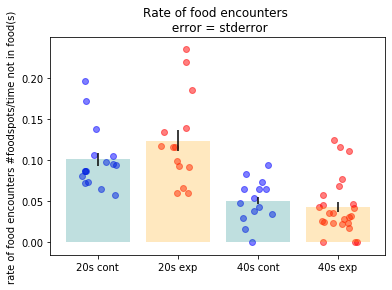

In [156]:
##active fly filtering

f_encounter_20c = run_function(Path_h5, trials_control_20, get_food_encounter_rate, is_active_fly)
f_encounter_20e = run_function(Path_h5, trials_exp_20, get_food_encounter_rate, is_active_fly)
f_encounter_40c = run_function(Path_h5, trials_control_40, get_food_encounter_rate, is_active_fly)
f_encounter_40e = run_function(Path_h5, trials_exp_40, get_food_encounter_rate, is_active_fly)

scatter_plot_conditions(f_encounter_20c, f_encounter_20e, f_encounter_40c, f_encounter_40e)
bar_plot_conditions(f_encounter_20c, f_encounter_20e, f_encounter_40c, f_encounter_40e)


plt.ylabel('rate of food encounters #foodspots/time not in food(s)')
x = [0,1,2,3]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp'] 
plt.xticks(x, my_xticks)
plt.title("Rate of food encounters \n error = stderror")

plt.show()
##not sure why there are so many in control 20 that are in food the whole time...check the opto there. 

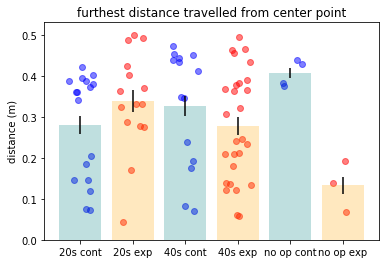

In [214]:
explore_20c = run_function(Path_h5, trials_control_20, get_furthest_explore)
explore_20e = run_function(Path_h5, trials_exp_20, get_furthest_explore)
explore_40c = run_function(Path_h5, trials_control_40, get_furthest_explore)
explore_40e = run_function(Path_h5, trials_exp_40, get_furthest_explore)
explore_nonec = run_function(Path_h5, trials_control_none, get_furthest_explore)
explore_nonee = run_function(Path_h5, trials_exp_none, get_furthest_explore)

#print(explore_20c)

scatter_plot_conditions(explore_20c, explore_20e, explore_40c, explore_40e, explore_nonec, explore_nonee)
bar_plot_conditions(explore_20c, explore_20e, explore_40c, explore_40e, explore_nonec, explore_nonee)
plt.title("furthest distance travelled from center point")
plt.ylabel("distance (m)")
x = [0,1,2,3,4,5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'no op cont', 'no op exp'] 
plt.xticks(x, my_xticks)
plt.show()

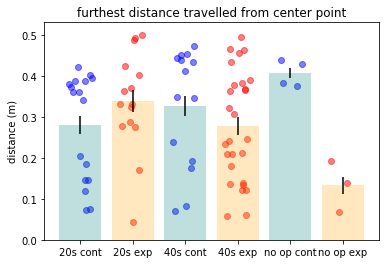

In [215]:
f_explore_20c = run_function(Path_h5, trials_control_20, get_furthest_explore, is_active_fly)
f_explore_20e = run_function(Path_h5, trials_exp_20, get_furthest_explore, is_active_fly)
f_explore_40c = run_function(Path_h5, trials_control_40, get_furthest_explore, is_active_fly)
f_explore_40e = run_function(Path_h5, trials_exp_40, get_furthest_explore, is_active_fly)
f_explore_nonec = run_function(Path_h5, trials_control_none, get_furthest_explore, is_active_fly)
f_explore_nonee = run_function(Path_h5, trials_exp_none, get_furthest_explore, is_active_fly)

#print(explore_20c)

scatter_plot_conditions(explore_20c, explore_20e, explore_40c, explore_40e, explore_nonec, explore_nonee)
bar_plot_conditions(explore_20c, explore_20e, explore_40c, explore_40e, explore_nonec, explore_nonee)
plt.title("furthest distance travelled from center point \n no sleepy flies")
plt.ylabel("distance (m)")
x = [0,1,2,3,4,5]
my_xticks = ['20s cont', '20s exp', '40s cont', '40s exp', 'no op cont', 'no op exp'] 
plt.xticks(x, my_xticks)
plt.show()

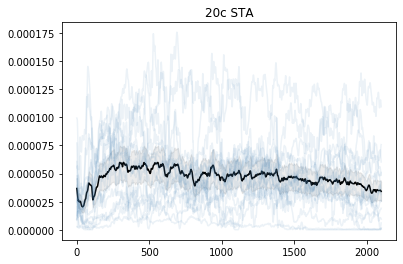

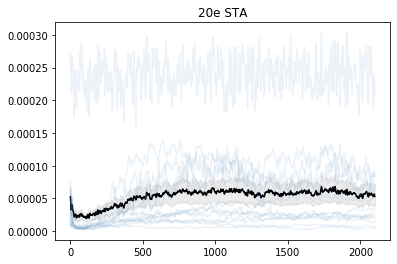

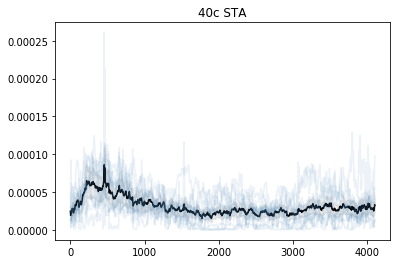

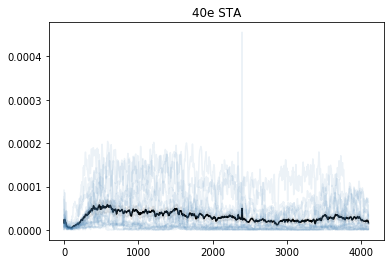

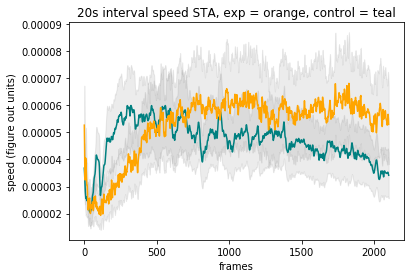

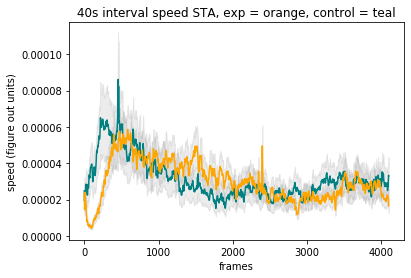

In [415]:
## STA from velocity


vel_STA_20c = run_function(Path_h5, trials_control_20, get_STA_mean, is_active_fly)
vel_STA_20e = run_function(Path_h5, trials_exp_20, get_STA_mean, is_active_fly)
vel_STA_40c = run_function(Path_h5, trials_control_40, get_STA_mean, is_active_fly)
vel_STA_40e = run_function(Path_h5, trials_exp_40, get_STA_mean, is_active_fly)

plot_STA_mean_fill (vel_STA_20c, single ='yes')
plt.title('20c STA')
plt.show()
plot_STA_mean_fill (vel_STA_20e, single ='yes')
plt.title('20e STA')
plt.show()
plot_STA_mean_fill (vel_STA_40c, single = 'yes')
plt.title('40c STA')
plt.show()
plot_STA_mean_fill (vel_STA_40e, single = 'yes')
plt.title('40e STA')
plt.show()

plot_STA_mean_fill (vel_STA_20c, color = 'teal')
plot_STA_mean_fill (vel_STA_20e, color = 'orange')
plt.title('20s interval speed STA, exp = orange, control = teal')
plt.ylabel('speed (figure out units)')
plt.xlabel('frames')
plt.show()
plot_STA_mean_fill (vel_STA_40c, color = 'teal')
plot_STA_mean_fill (vel_STA_40e, color = 'orange')
plt.title('40s interval speed STA, exp = orange, control = teal')
plt.ylabel('speed (figure out units)')
plt.xlabel('frames')
plt.show()

# 3.6.23 NEXT TIME!! 
1.  get furthest distance travlled
2.  get time spent near foodspot
3.  adjust so keep sleepy flies but take only times before fall asleep
4. get STA for speed
5. fix foodspot bool so doesn't count before they get to that foodspot



# Testing area

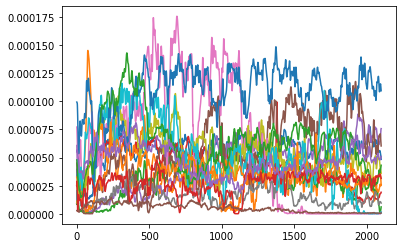

(16, 2100)
[3.67962579e-05 3.59836533e-05 3.47837446e-05 ... 3.45731899e-05
 3.43325718e-05 3.41573206e-05]
[2.57956390e-05 2.53699886e-05 2.47842964e-05 ... 2.99523072e-05
 2.95359422e-05 2.91559228e-05]
2100


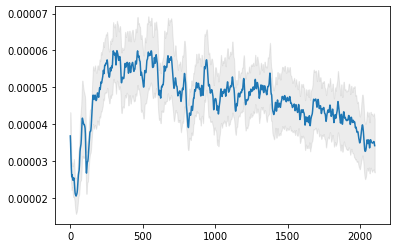

In [394]:
for fly in vel_STA_20c:
    if fly is not None:
        plt.plot(fly)
plt.show()

STA = [np.array(fly, dtype = np.float64) for fly in vel_STA_20c if fly is not None]
#print(STA)
print(np.shape(STA))

mean = np.nanmean(STA, axis = 0)
print(mean)
plt.plot(mean)
std = np.std(STA, axis = 0)
print(std)
print(len(mean))
sterr = std/np.sqrt(len(STA))
x = range(len(mean))

plt.fill_between(x, mean + sterr, mean - sterr, color = 'grey', alpha = .15)
plt.show()

33
<KeysViewHDF5 ['age', 'angular velocity', 'average distance to any foodspot', 'condition', 'distance matrix', 'experiment', 'experiment length', 'fly angle', 'food encounter rate', 'food radius (mm)', 'genotype', 'in foodspot bool', 'keep light on for full on time', 'led times', 'max on time (s)', 'min off time (s)', 'minimum distance to foodspot all times', 'opto x', 'opto y', 'timepoints', 'total foodspots', 'total time in foodspots', 'trial', 'user', 'velocity', 'x raw', 'y raw']>
[2001, 4102, 6202, 8303, 10403, 12503, 14604, 16705, 18805, 20906, 23007, 25107, 27207, 29308, 31409, 33510, 35611, 37711, 39812, 41913, 44013, 46114, 48215, 50315, 52415, 54516, 56616, 58716]
28
23
(59703, 28)


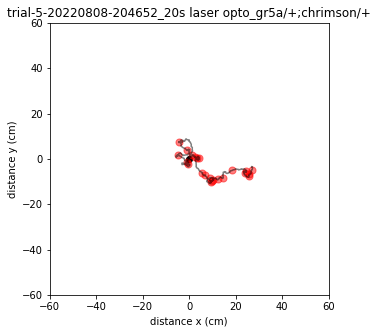

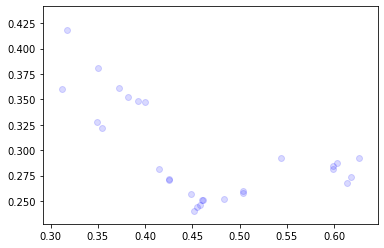

(59703, 28)
28
28


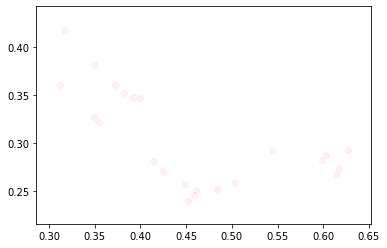

In [454]:
fly = 11  #fly 0 and fly 10 for trials_control_20 are different problems
print(len(trials_control_20))
trial = trials_exp_20[fly]
Path = os.path.join(Path_h5, trial + '.h5')


##fixing in_foodspot_bool so it only counts if its in the foodspot after the light turns on. 
# problem is that there are different numbers of foodspots based on optox and timepoints...
# should use timepoints instead not sure how its generating foodspot anymore
# distance matrix with timepoints instead

##new distance matrix
with h5py.File(Path, 'a') as f:
    if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
        flyx = f['x raw'][()]
        flyy = f['y raw'][()]
#             optox = f['opto x'][()]
#             optoy = f['opto y'][()]
        opto_on_indices = find_opto_indices (Path)
        optox = flyx[opto_on_indices]
        optoy = flyy[opto_on_indices]

        distance_matrix = np.sqrt(
        (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
        (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
        )
        print(np.shape(distance_matrix))
        print(len(optox))
        print(len(opto_on_indices))

with h5py.File(Path, 'a') as f:
    if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
        foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
        framerate = .01 ##always .01s for big rig camera
        print(f.keys())
        x = f['x raw'][()]
        y = f['y raw'][()]
        opto_x = f['opto x'][()]
        opto_y = f['opto y'][()]

#         if 'distance matrix' in f.keys():
#             distance_matrix = f['distance matrix'][()]
#         else:
        distance_matrix = get_foodspot_distance_matrix(Path) #, quiet)

        ##need to see if the light has turned on yet too
        opto_on_indices = find_opto_indices (Path)
        print(opto_on_indices)
        print(len(opto_on_indices))
        print(len(f['opto x'][()]))
        print(np.shape(distance_matrix))
        in_foodspot_bool = distance_matrix < foodspot_radius  
        ##I want this to be false up to the index that the foodspot is present (opto_on_indices for that foodspot)

        ## add to h5 files
        #add_to_h5(Path, 'in foodspot bool', in_foodspot_bool) #true if fly in foodspot duringt that frame
    else:
        if quiet == 'n':
            print(f'no data for this fly')
        in_foodspot_bool = None
make_line_plots (Path, save = 'n', savePath = Path)


# for index in opto_on_indices:
#     plt.scatter(x[index], y[index], color = 'blue', alpha = .15)
# plt.show()
# plt.scatter(opto_x, opto_y, color = 'red', alpha = .05)


## distance matrix code
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
#             flyx = f['x raw'][()]
#             flyy = f['y raw'][()]
#             optox = f['opto x'][()]
#             optoy = f['opto y'][()]
            
#             distance_matrix = np.sqrt(
#             (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
#             (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
#             )


# distance matrix with timepoints instead
with h5py.File(Path, 'a') as f:
    if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
        flyx = f['x raw'][()]
        flyy = f['y raw'][()]
#             optox = f['opto x'][()]
#             optoy = f['opto y'][()]
        opto_on_indices = find_opto_indices (Path)
        optox = flyx[opto_on_indices]
        optoy = flyy[opto_on_indices]

        distance_matrix = np.sqrt(
        (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
        (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
        )
        print(np.shape(distance_matrix))
        print(len(optox))
        print(len(opto_on_indices))

(59703, 28)
(59703, 28)


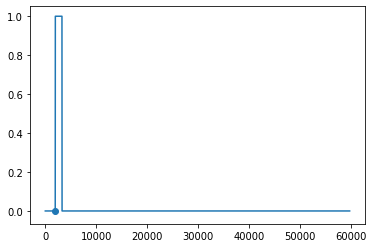

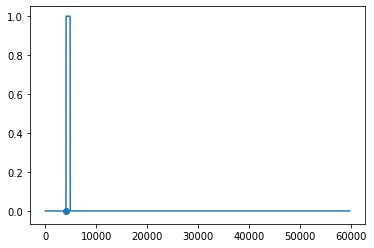

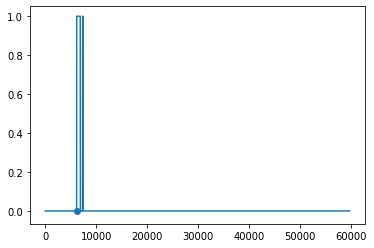

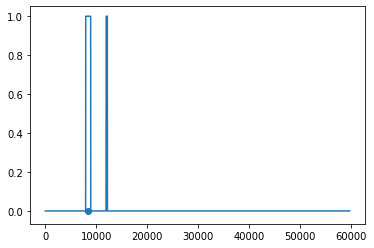

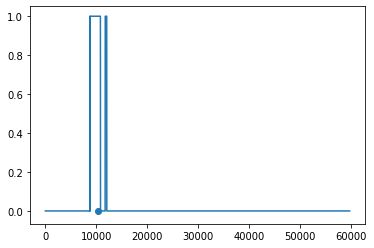

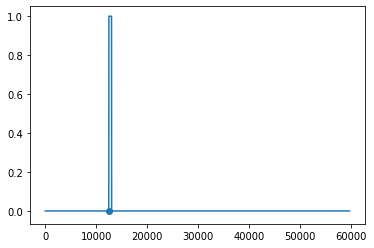

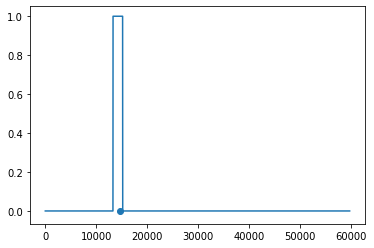

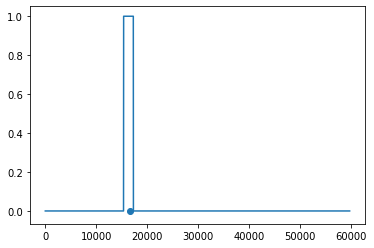

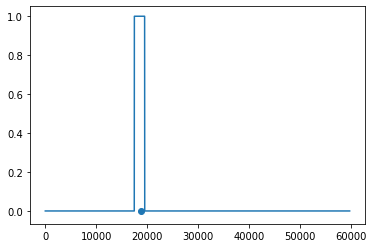

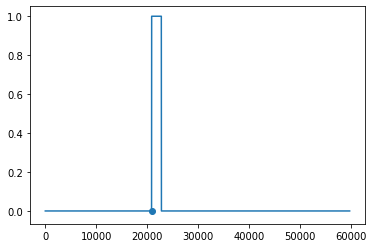

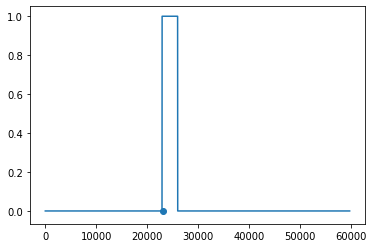

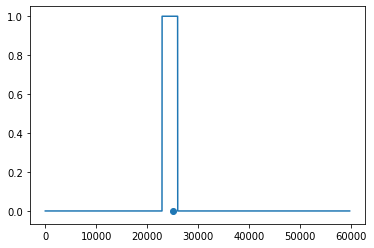

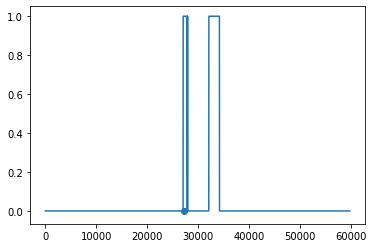

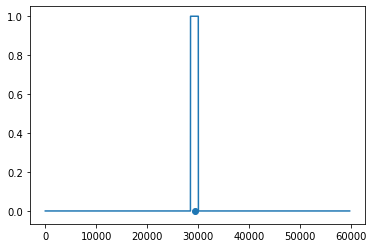

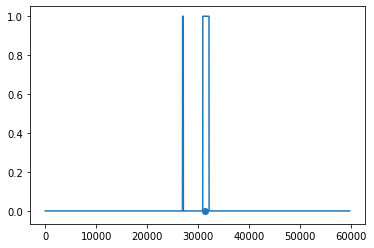

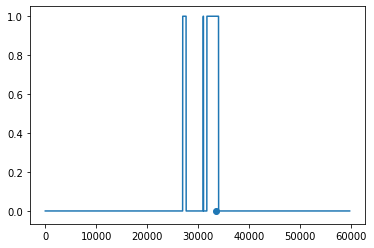

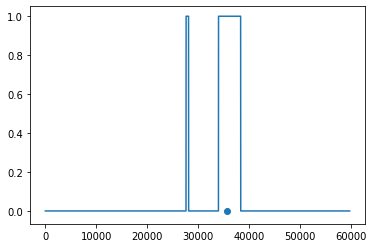

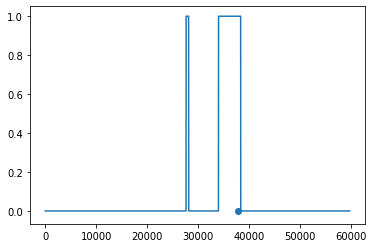

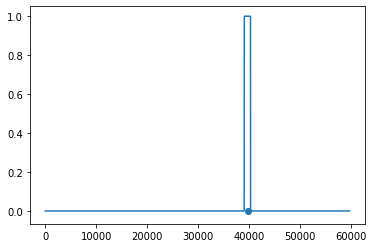

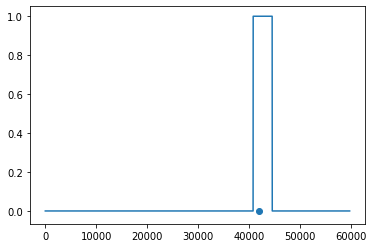

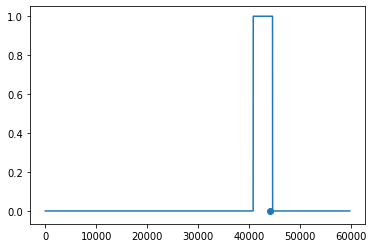

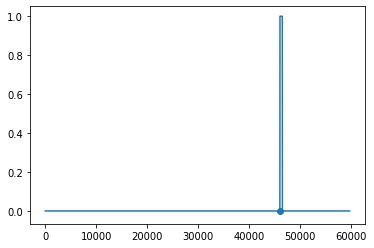

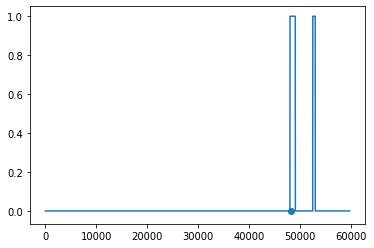

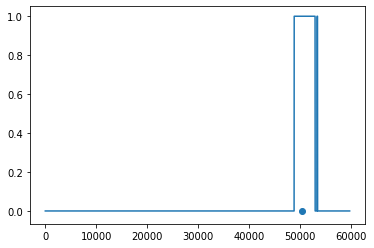

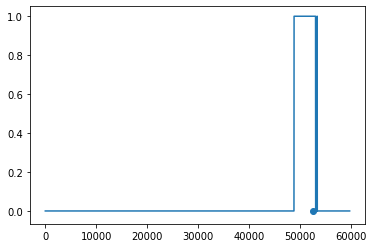

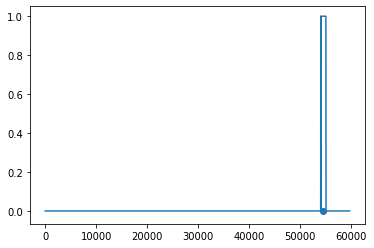

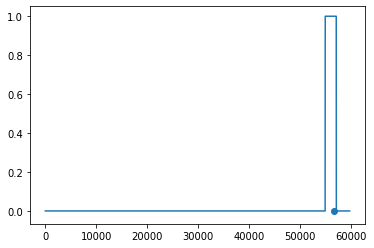

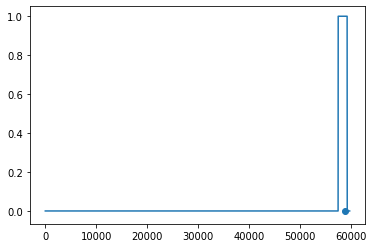

In [476]:
# plt.plot(distance_matrix[0])
# plt.scatter(optox[0], optoy[0])
# plt.scatter(optox, optoy)
# plt.show()
# # plt.show()
# print(np.shape(distance_matrix))
# print(len(distance_matrix[0]))
# print(distance_matrix[:][0])
# print(len(distance_matrix[0][:]))
# print(len(distance_matrix[:,0]))
# print(len(distance_matrix[:]))
# print(len(distance_matrix[0]))
print(np.shape(in_foodspot_bool))
# for food_index in range(len(distance_matrix[0])):
#     plt.plot(distance_matrix[:,food_index])
#     plt.scatter(opto_on_indices[food_index], optoy[food_index])
#     plt.show()
    
print(np.shape(in_foodspot_bool))
for food_index in range(len(in_foodspot_bool[0])):
    plt.plot(in_foodspot_bool[:,food_index])
    plt.scatter(opto_on_indices[food_index], 0)
    plt.show()
    

sleep start and stop []


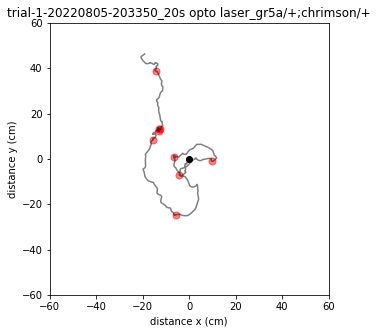

In [338]:
##truncate sleepy flies by stopping experiment when get sleepy 
#(fly10 has an odd sleep, must have just been moving very slow)
# fly = 11  #fly 0 and fly 10 for trials_control_20 are different problems
# trial = trials_control_20[fly]
# Path = os.path.join(Path_h5, trial + '.h5')
print('sleep start and stop', check_if_asleep(Path))
make_line_plots (Path, save = 'n', savePath = Path)

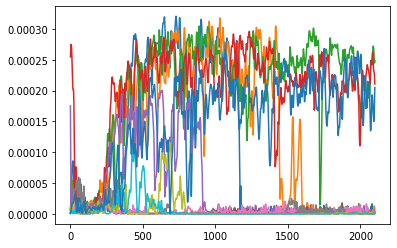

(11, 2100)
(11,)


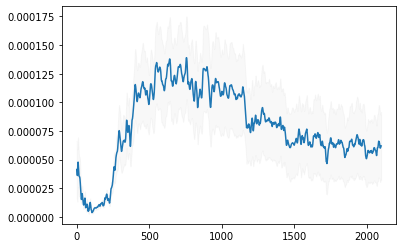

In [339]:
all_trials = get_velocity_STA(Path)

#find min length all_trials
shortest_trial_length = min(map(len, all_trials))

for trial in all_trials:
    plt.plot(trial[0:shortest_trial_length])
plt.show()


truncated_trials = []
for trial in all_trials:
    truncated_trials.append(trial[0:shortest_trial_length])
print(np.shape(truncated_trials))
print(np.shape(all_trials))
plt.plot(np.mean(truncated_trials, axis = 0))

##change this to be real trials
mean = np.mean(truncated_trials, axis = 0)
std = np.std(truncated_trials, axis = 0)
sterr = std/np.sqrt(len(truncated_trials))
x = range(shortest_trial_length)

plt.fill_between(x, mean + sterr, mean - sterr, color = 'grey', alpha = .05)




In [256]:
a = [1,2,3,4,5,6,7,8]
a = np.array(a)

a = [1,2,3,4,5,6,7,8]
a = np.array(a)

a = [1,2,3,4,5,6,7,8]
a = np.array(a)

print(np.where(3.75<=a)[0])

[3 4 5 6 7]


In [182]:
## find time spent 3cm from foodspot 
#(may get confusing if gets second foodspot in this window...but it is still staying close so I think it should still count)

#1. find when it's in a foodspot
#2. find when it gets 3cm from that foodspot


#I think I can just change my in foodspot bool to see if it is 3cm from foodspot

## THIS NEEDS TO BE ADJUSED TO ONLY CARE ABOUT IN FOODSPOT IF AFTER THE FODOSPOT APPEARS
## ALSO CHANGE SO MUST BE CONTIGUOUS (REMOVE TIMES AFTER LEAVES 3CM RADIUS)
def in_foodspot_area_bool (Path, radius = .03 , quiet = 'y'):
    """input path to h5 trial file. and radius around foodspot care about in meters
    returns: 
    -bool for every frame the fly is in a foodspot (also calculated and saved in total food)
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            framerate = .01 ##always .01s for big rig camera
            
            if 'distance matrix' in f.keys():
                distance_matrix = f['distance matrix'][()]
            else:
                distance_matrix = get_foodspot_distance_matrix(Path, quiet)
            in_foodspot_bool = distance_matrix < radius
            
            ## add to h5 files
            add_to_h5(Path, 'in foodspot bool', in_foodspot_bool) #true if fly in foodspot duringt that frame
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            in_foodspot_bool = None
        
       # return in_foodspot_bool


fly = 11  #fly 0 and fly 10 for trials_control_20 are different problems
trial = trials_control_20[fly]
Path = os.path.join(Path_h5, trial + '.h5')

foodspot_bool = get_in_foodspot_bool (Path)
foodspot_area_bool = in_foodspot_area_bool(Path, radius = .03)

print(sum(foodspot_area_bool))
print(sum(foodspot_bool))
print(len(sum(foodspot_bool)))
print(len(foodspot_bool))
print(np.shape(foodspot_bool))
with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            flyx = f['x raw'][()]
            flyy = f['y raw'][()]
            optox = f['opto x'][()]
            optoy = f['opto y'][()]
            foodspot_radius = float(f['food radius (mm)'][()])
            
            print(len(flyx))
            print(len(optox))
            print(foodspot_radius)

# framerate = .01 #frames/s

# get_foodspot_distance_matrix (Path, quiet = 'n'):
#     """input path and get out distance matrix that calculates distance to closest foodspot for every fly position
#     Checks if fly moves 3cm away from hole and excludes otherwise"""
#     with h5py.File(Path, 'a') as f:
#         if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
#             flyx = f['x raw'][()]
#             flyy = f['y raw'][()]
#             optox = f['opto x'][()]
#             optoy = f['opto y'][()]
            
#             distance_matrix = np.sqrt(
#             (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
#             (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
#             )

[3449 3365 2445 3774 3136 1279 2545 2437  965  763  950 6177 1295 2227
 1037  916]
[2244 2145  617  528 1576  710  934  347  122   98  409 5546  666 1553
  331   91]
16
34311
(34311, 16)
34311
16
0.005


[False False False ... False False False]
(34311, 16)
34311


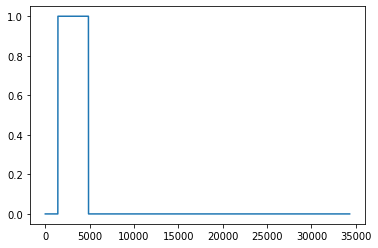

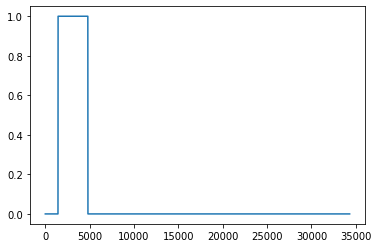

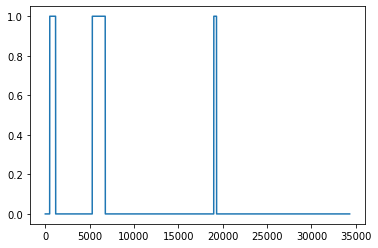

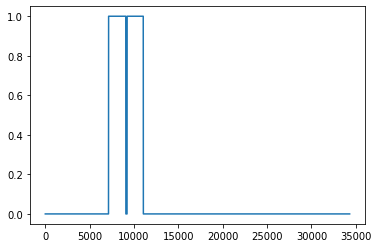

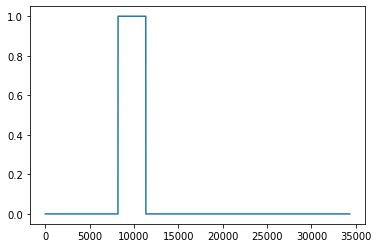

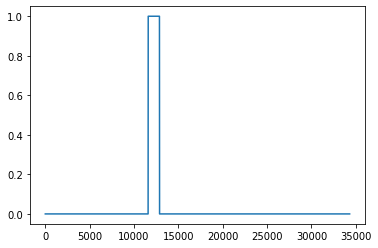

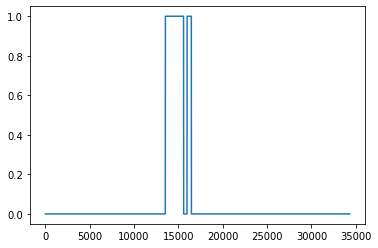

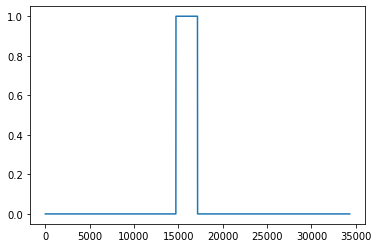

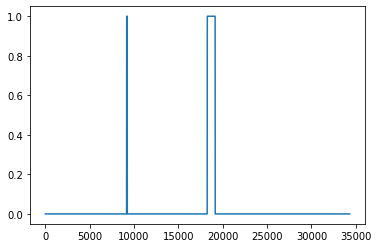

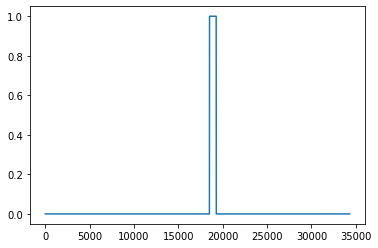

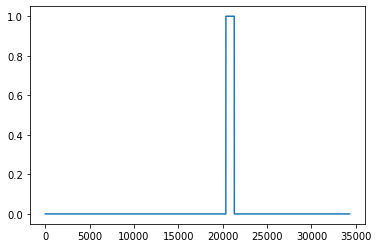

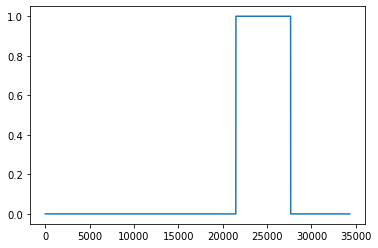

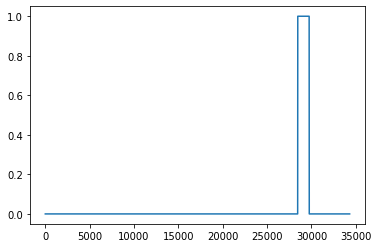

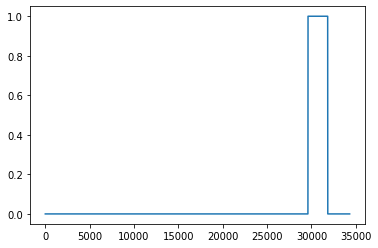

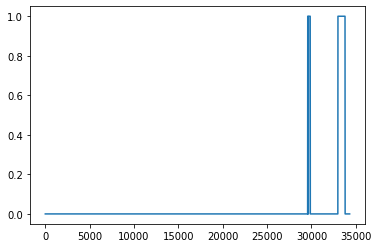

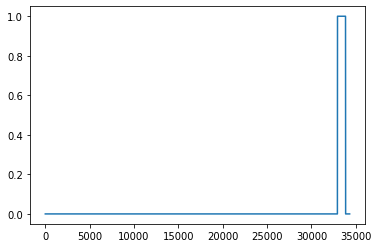

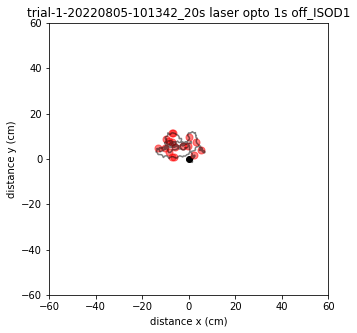

In [228]:
fly = 0  #fly 0 and fly 10 for trials_control_20 are different problems
trial = trials_control_20[fly]
Path = os.path.join(Path_h5, trial + '.h5')

print(foodspot_area_bool[:,0])
print(np.shape(foodspot_area_bool))
print(len(foodspot_area_bool))
for i in range(len(foodspot_area_bool[0])):
    plt.plot(foodspot_area_bool[:,i])
    plt.show()
make_line_plots (Path, save = 'n', savePath = Path)

##how should I handle this situation where the fly never really gets that far from the foodspots...?

## FUNCTIONS

In [414]:
def plot_STA_mean_fill (STA_data, color = 'black', single = 'no'):
    """Will take sta individual fly means, filter out None lists, calc overall mean, std, sterr and plot, 
    not currently returning anything"""
    
    STA_data_filtered = [fly for fly in STA_data if fly is not None]
    shortest_interval = min(map(len, STA_data_filtered))
    STA_data_filtered = [fly[0:shortest_interval] for fly in STA_data_filtered]
    mean = np.mean(STA_data_filtered, axis = 0)
    std = np.mean(STA_data_filtered, axis = 0)
    sterr = std/np.sqrt(len(STA_data_filtered))
    plt.plot(mean, color = color)
    x = range(len(mean))
    plt.fill_between(x, mean + sterr, mean - sterr, color = 'grey', alpha = .15)
    if single == 'yes':
        for fly_STA in STA_data_filtered:
            plt.plot(fly_STA, alpha = .1, color = 'steelblue')

In [416]:
def get_STA_mean (Path, quiet = 'y'):
    """takes path and generates STA from velocity by splitting each trial and then averaging across
    returns single mean for one fly"""
    #print(Path)
    all_trials = get_velocity_STA(Path)
    if all_trials is not None and len(all_trials) > 0:
        #print('not none')
        #find min length all_trials (some are off by 1 frame)
        shortest_trial_length = min(map(len, all_trials))

        truncated_trials = []
        for trial in all_trials:
            truncated_trials.append(trial[0:shortest_trial_length])
        mean = np.mean(truncated_trials, axis = 0)

        return mean
        

In [259]:
def get_light_on_times (Path):
    """use led times to find light on (looks for light time difference< 3s)"""
    light_on_length = 3 # actually 1s but this should be fine
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            led_times = f['led times'][()]
            light_on_times = []
            for time_i in range(len(led_times)-1):
                current_time = led_times[time_i]
                next_time = led_times[time_i + 1]
                if next_time - current_time < light_on_length:
                    light_on_times.append(current_time)

            return light_on_times

In [265]:
def find_opto_indices (Path):
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            timepoints = f['timepoints'][()]
            #find times opto on
            light_on_times = get_light_on_times (Path)

            #find frames light on (correspond to indices)
            opto_on_indices = []
            for time in light_on_times:
                #find index in timepoints that is just greater than timepoint
                index = np.where(time<=timepoints)[0][0]
                opto_on_indices.append(index)
            return opto_on_indices

In [313]:
def get_velocity_STA (Path):
    """looks at frames light turns on and returns list of lists of velocity between light flashes
    skips velocity before the first light flash and after the last light flash"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:

            velocity = f['velocity'][()]  

            #get indices for when the light turns on
            opto_indices = find_opto_indices (Path)

            ##trials will be in frames
            all_trials = []
            for i in range(len(opto_indices)-1):
                ##start trials after first light flash
                current_light_index = opto_indices[i] 
                next_light_index = opto_indices[i+1]
                trial = velocity[current_light_index:next_light_index]
                all_trials.append(trial)
            return all_trials
    

        
    
        


In [208]:
##get furthest distance to center

def get_furthest_explore (Path, quiet = 'y'):
    """get furthest distance fly gets from the center. does not require opto, but does require explorer"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and check_if_explorer(Path) is True: 
            flyx = f['x raw'][()]
            flyy = f['y raw'][()]
            centerx = flyx[0]
            centery = flyy[0]
            
            distance = np.sqrt((flyx - centerx)**2 + (flyy - centery)**2)
            #print(distance)
            max_distance = np.max(distance)
            return max_distance

In [107]:
def is_active_fly(Path):
    """input path to specific h5 trial.
    checks if fly is not sleepy and an explorer with check_if_explorer and check_if_asleep functions 
    => requires the fly to move 3cm from hole and to not be still for more than 3 min
    returns True if active fly and False if not"""
    not_explorer = 0 #means never traveled more than 3cm away
    sleepy_explorer = 0 ##means travedled 3cm away but also fell asleep during trial
    if check_if_asleep(Path) and len(check_if_asleep(Path)) > 0:
        if (check_if_explorer(Path)) is False:
            #print("not explorer")  ##could use these for something later
            not_explorer = not_explorer + 1
        else:
            #print("sleepy explorer")
            sleepy_explorer = sleepy_explorer + 1
        return False
    else:
        return True
    

In [43]:
def make_not_none_mask (array):
    mask = array != None
    return mask

In [44]:
#write function to exclude flies that sit at the hole and fall asleep (may also not be flies, may be hole errors)
#if dont get certain euc distance from hole then don't use (let's say 3cm)
def check_if_explorer (Path):
    """input specific trial path and outputs figure in savePath. Must be to h5 file! 
    will look to see if a fly travels 3cm in any direction away from the hole and return False if it does not, 
    will return True if it does explore"""
    
    #get data
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and f['x raw'][()] is not None:
            x = f['x raw'][()]
            y = f['y raw'][()]
            center_x = x[0] #starting positions
            center_y = y[0]
            required_distance = 3 #3 = 3cm bc I adjust for cm later by mult by 100
            #find max x and y and see if either are further than 3 cm, if so don't need to worry about euc calculations
            if (max(abs(x - center_x)))*100 > required_distance or (max(abs(y - center_y)))*100 > required_distance:
                return True
                
            else:
                #check distance                                                
                distance = np.sqrt((x - center_x)**2 + (y - center_y)**2)*100
                if max(distance) > required_distance:
                    return True
                else:
                    return False

In [137]:
def run_function (Path_h5, trials, function, conditional_function = None, quiet = 'y'):
    """"""
    data_list = []
    for trial in trials:
        Path = os.path.join(Path_h5, str(trial) + '.h5')
        if conditional_function is not None:
            if conditional_function(Path):
                data_list.append(function(Path, quiet = quiet))
        else:
            data_list.append(function(Path, quiet = quiet))
            #print('no conditional function')
    return data_list


In [110]:
def run_on_all_trials_mean(Path_h5, trials, function, conditional_function = None, quiet = 'y'):
    """takes path to h5 files and trial name list and builds path to individual trials 
    then runs specified function over them and appends to a list that is returned
    calculates the mean for each trial and appends that"""
    data_list = []
    for trial in trials:
        Path = os.path.join(Path_h5, trial + '.h5')
        if conditional_function is not None:
            if conditional_function(Path):
                data_list.append(np.nanmean(function(Path, quiet = quiet), dtype=np.float64))
        else:
            data_list.append(np.nanmean(function(Path, quiet = quiet), dtype=np.float64))
    return data_list
    

In [46]:
def run_on_all_trials(Path_h5, trials, function, quiet = 'y'):
    """takes path to h5 files and trial name list and builds path to individual trials 
    then runs specified function over them and appends to a list that is returned
    ***same as run_function but doesn't have conditional"""
    data_list = []
    for trial in trials:
        Path = os.path.join(Path_h5, trial + '.h5')
        data_list.append(function(Path, 'y'))
    return data_list
    

In [153]:
##check if asleep
#a fly is asleep if it stays in the same place for more than 5 minutes (I'm declaring)

def check_if_asleep (Path):
    """returns indices where the fly is asleep (still for 5 min or more)"""
    ##want the time and x,y where fly falls asleep (later may just want time...to eliminate the experiment after)
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and f['x raw'][()] is not None:
            x = f['x raw'][()]
            y = f['y raw'][()]
            center_x = x[0] #starting positions
            center_y = y[0]
            velocity = f['velocity'][()]  

            ##check if velocity is low for a while
            min_velocity = .00001  #this may need adjustment
            still_length_minutes = 5 #time in minutes fly is allowed to be still
            framerate = .01 #frames/s
            still_length_frames = int(still_length_minutes*60 /framerate) #number of frames the fly is allowed to be still for

            sleep_indices = [] #put in start and stop as tuples
            zero_collect = [] #won't actually be "zero" but will be less than min velocity
            for vel_index in range(len(velocity)):
                #make sure index isn't zero and current velocity and prev velocity were zero
                if vel_index != 0 and velocity[vel_index] < min_velocity: # and velocity[vel_index -1] < min_velocity:
                    zero_collect.append(index)
                    #last index condition
                    if vel_index == (len(velocity) - 1) and len(zero_collect) >= still_length_frames: #check if it meets min still time
#                         print("SLEEPY FLY last sleepy frame = ", vel_index)
#                         print("sleepy fly first sleepy frame =", zero_collect[0])
                        sleep_indices.append((zero_collect[0], vel_index)) #start and stop
                        zero_collect = []
                    elif len(zero_collect) >= still_length_frames and velocity[vel_index + 1] > min_velocity: #zero string sufficiently long
#                         print("SLEEPY FLY last sleepy frame = ", index)
#                         print("sleepy fly first sleepy frame =", zero_collect[0])
                        sleep_indices.append((zero_collect[0], vel_index)) #start and stop
                        zero_collect = []
                else:
                    zero_collect = [] #reset sleep collector

            return sleep_indices


In [140]:
def bar_plot_conditions(a,b=None, c=None, d=None, e=None, f=None, *args):
    """takes in list of values for each condition and bar plots the mean and plots std
    will also get rid of None values and nan values in list
    ---colors hardcoded to alternate"""
    ##in future just have *args and input a list then iterate over the list of conditions
    
    float_a = np.array(a, dtype=np.float64)
    plt.bar(0, np.nanmean(float_a), yerr=np.nanstd(float_a)/np.sqrt(len(float_a)), alpha = .25, color = 'teal')
    if b is not None:
        float_b = np.array(b, dtype=np.float64)
        plt.bar(1, np.nanmean(float_b), yerr=np.nanstd(float_b)/np.sqrt(len(float_b)), alpha = .25, color = 'orange')
    if c is not None:
        float_c = np.array(c, dtype=np.float64)
        plt.bar(2, np.nanmean(float_c), yerr=np.nanstd(float_c)/np.sqrt(len(float_c)), alpha = .25, color = 'teal')
    if d is not None:
        float_d = np.array(d, dtype=np.float64)
        plt.bar(3, np.nanmean(float_d), yerr=np.nanstd(float_d)/np.sqrt(len(float_d)), alpha = .25, color = 'orange')
    if e is not None:
        float_e = np.array(e, dtype=np.float64)
        plt.bar(4, np.nanmean(float_e), yerr=np.nanstd(float_e)/np.sqrt(len(float_e)), alpha = .25, color = 'teal')
    if f is not None:
        float_f = np.array(f, dtype=np.float64)
        plt.bar(5, np.nanmean(float_f), yerr=np.nanstd(float_f)/np.sqrt(len(float_f)), alpha = .25, color = 'orange')

In [49]:
def scatter_plot_conditions (a,b=None,c=None,d=None,e=None,f=None):
    """each input is a different condition variable for y, scatter plots will plot with random x jitter
    --colors hardcoded for fast plotting
    """
    
    plt.scatter(np.random.rand(len(a))/2-.25, a, alpha = .5, color = 'blue')
    if b is not None:
        plt.scatter(np.random.rand(len(b))/2 + .75, b, alpha = .5, color = 'red')
    if c is not None:
        plt.scatter(np.random.rand(len(c))/2+ 1.75, c, alpha = .5, color = 'blue')
    if d is not None:
        plt.scatter(np.random.rand(len(d))/2+ 2.75, d, alpha = .5, color = 'red')
    if e is not None:
        plt.scatter(np.random.rand(len(e))/2+ 3.75, e, alpha = .5, color = 'blue')
    if f is not None:
        plt.scatter(np.random.rand(len(f))/2+ 4.75, f, alpha = .5, color = 'red')
    #plt.show()
    

In [50]:
def make_line_plots (Path, save = 'n', savePath = Path):
    """input specific trial path and outputs figure in savePath. Must be to h5 file! 
    If save and save path are not specified then it will not save. 
    If save is specified but savePath is not then a new folder in Path will be created"""
    
    #get data
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and f['x raw'][()] is not None:
            x = f['x raw'][()]
            y = f['y raw'][()]
            center_x = x[0] #starting positions
            center_y = y[0]
            
            fig1 = plt.figure(figsize=(5,5))
            ax1 = fig1.add_subplot(111)
            plt.xlim(-60,60)
            plt.ylim(-60,60)
            plt.xlabel("distance x (cm)")
            plt.ylabel("distance y (cm)")
            condition = f['condition'][()]
            genotype = f['genotype'][()]
            fly_name = f['trial'][()]
            plt.title(str(condition)+ '_' + str(genotype) + '\n' + str(trial))
            
            plt.plot((x - center_x)*100, (y-center_y)*100, color = 'black', alpha = .5)
            plt.scatter(0, 0, color = 'black') #center dot
            
            if 'opto x' in f.keys() and f['opto x'] is not None:
                opto_x = f['opto x'][()]
                opto_y = f['opto y'][()]
                plt.scatter((opto_x-center_x)*100, (opto_y-center_y)*100, s = 50, color = 'red', alpha = .5)
            
            plt.title(str(fly_name) + '_' + str(condition) + '_' + str(genotype))    
            plt.show()
                
        else:  #have print if no x!
            print(f"There is no xy tracking data for this fly: {trial}")
            #break
            
            
    #make save location if none specified
    if savePath == Path and save == 'y':
        up_one = os.path.split(Path)[0]
        savePath = os.path.join(up_one, 'line_plots')
        if os.path.exists(savePath):
            print('path exists')
        else:
            os.makedirs(savePath)
    
    #save if requested
    if save == 'y':
        fig1.savefig(os.path.join(savePath, str(genotype)+ '_' + str(condition) + '_' + str(trial) + '_PATH.png'))


In [51]:
def add_to_h5(Path, key, value):
    """adds new key value to h5 file and checks if it already exists
    does overwrite"""
    with h5py.File(Path, 'a') as f:
        if key not in f.keys(): #check if key already in file
            f[key] = value
        else:
            del f[key]
            #print('deleting old key and OVERWRITING')
            f[key] = value

        

In [52]:
## Experiment length
def get_experiment_length(Path, quiet = 'n'):
    """get experiment length for each trial and add to h5py
    as of 1-26-23 there is a timeout on the big rig that prevents flies from staying longer than 30min"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and f['x raw'][()] is not None:
            x = f['x raw'][()]
            framerate = .01 #frames/s
            experiment_length = len(x)*framerate
            add_to_h5(Path, 'experiment length', experiment_length) #time in any foodspot            
        else:
            if quiet == 'n':
                print("no xy data for trial")
            experiment_length = None
            
        return experiment_length

In [452]:
def get_foodspot_distance_matrix (Path, quiet = 'n'):
    """input path and get out distance matrix that calculates distance to closest foodspot for every fly position
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            flyx = f['x raw'][()]
            flyy = f['y raw'][()]
    #             optox = f['opto x'][()]
    #             optoy = f['opto y'][()]
            ##use opto_on timepoints instaed of foodspot x,y to find
            opto_on_indices = find_opto_indices (Path)
            optox = flyx[opto_on_indices]
            optoy = flyy[opto_on_indices]

            distance_matrix = np.sqrt(
            (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
            (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
            )
            
            add_to_h5(Path, 'distance matrix', distance_matrix) #time in any foodspot            
        else:
            if quiet == 'n':
                print("no xy daya for trial")
            distance_matrix = None  #so it doesn't break code if it can't find one trial with distance matrix
            
        return distance_matrix

In [54]:
## this gets all the parameters, but I'm going to make individual functions to get 
##individual parameters since its nice to not worry about returning 4 things

def get_foodspot_parameters (Path, quiet = 'n'):  
    """input path to h5 trial file. 
    returns: 
    -total foodspots
    -total time in foodspots
    -min distance to any foodspot at all times 
    -avg min distance from foodspot
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
            framerate = .01 ##always .01s for big rig camera
        
            if 'distance matrix' in f.keys():
                distance_matrix = f['distance matrix'][()]
            else:
                distance_matrix = get_foodspot_distance_matrix(Path, quiet)
    
            in_foodspot_bool = distance_matrix < foodspot_radius
        
            total_time_in_foodspot = np.sum(in_foodspot_bool, axis=0)*framerate
            min_distance = np.min(distance_matrix, axis=1) #minimum distance to any foodspot at all times
            foodspot_avg_dist = min_distance.mean() #average distance to foodspot
            total_foodspots = len(optox)
            
            ## add to h5 files
            add_to_h5(Path, 'total time in foodspots', total_time_in_foodspot) #time in any foodspot
            add_to_h5(Path, 'minimum distance to foodspot all times', min_distance) #distance to closest foodspot for all times
            add_to_h5(Path, 'average distance to any foodspot', foodspot_avg_dist) #average distance to closest foodspot across time
            add_to_h5(Path, 'total foodspots', total_foodspots)
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            total_time_in_foodspot = None
            min_distance = None
            foodspot_avg_dist = None
            total_foodspots = None
        
        return total_time_in_foodspot, min_distance, foodspot_avg_dist, total_foodspots

        
            

In [55]:
def get_total_time_in_foodspots (Path, quiet = 'n'):
    """input path to h5 trial file. 
    returns: 
    -total time in foodspots
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
            framerate = .01 ##always .01s for big rig camera
        
            if 'distance matrix' in f.keys():
                distance_matrix = f['distance matrix'][()]
            else:
                distance_matrix = get_foodspot_distance_matrix(Path, quiet)
    
            in_foodspot_bool = distance_matrix < foodspot_radius
            total_time_in_foodspot = np.sum(in_foodspot_bool, axis=0)*framerate
            
            ## add to h5 files
            add_to_h5(Path, 'total time in foodspots', total_time_in_foodspot) #time in any foodspot
            add_to_h5(Path, 'in foodspot bool', in_foodspot_bool) #true if fly in foodspot duringt that frame

        else:
            if quiet == 'n':
                print(f'no data for this fly')
            total_time_in_foodspot = None
        
        return total_time_in_foodspot
     
        
            

In [56]:
def get_in_foodspot_bool (Path, quiet = 'n'):
    """input path to h5 trial file. 
    returns: 
    -bool for every frame the fly is in a foodspot (also calculated and saved in total food)
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
            framerate = .01 ##always .01s for big rig camera
            
            if 'distance matrix' in f.keys():
                distance_matrix = f['distance matrix'][()]
            else:
                distance_matrix = get_foodspot_distance_matrix(Path, quiet)
            
            ##need to see if the light has turned on yet too
            opto_on_indices = find_opto_indices (Path)
            in_foodspot_bool = distance_matrix < foodspot_radius
            
            ## add to h5 files
            add_to_h5(Path, 'in foodspot bool', in_foodspot_bool) #true if fly in foodspot duringt that frame
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            in_foodspot_bool = None
        
        return in_foodspot_bool
     

In [57]:
def get_total_foodspots (Path, quiet = 'n'):
    """input path to h5 trial file. 
    returns: 
    -total foodspots
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            total_foodspots = len(f['opto x'][()])
            
            ## add to h5 files
            add_to_h5(Path, 'total foodspots', total_foodspots)

        else:
            if quiet == 'n':
                print(f'no data for this fly')

            total_foodspots = None
        return total_foodspots

        
            

In [58]:
## this gets all the parameters, but I'm going to make individual functions to get 
##individual parameters since its nice to not worry about returning 4 things

def get_min_distance_any_foodspot (Path, quiet = 'n', save = 'y'):  
    """input path to h5 trial file. 
    returns: 
    -min distance to any foodspot at all times 
    -also adds average distance to h5 file
    and adds these to h5 file
    (quiet prevents printing)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
            framerate = .01 ##always .01s for big rig camera
        
            if 'distance matrix' in f.keys():
                distance_matrix = f['distance matrix'][()]
            else:
                distance_matrix = get_foodspot_distance_matrix(Path, quiet)
        
            min_distance = np.min(distance_matrix, axis=1) #minimum distance to any foodspot at all times
            foodspot_avg_dist = min_distance.mean() #average distance to foodspot

            ## add to h5 files
            if save == 'y':
                add_to_h5(Path, 'minimum distance to foodspot all times', min_distance) #distance to closest foodspot for all times
                add_to_h5(Path, 'average distance to any foodspot', foodspot_avg_dist) #average distance to closest foodspot across time
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            min_distance = None
            foodspot_avg_dist = None
        
        return min_distance

        
            

In [59]:
def get_avg_foodspot_duration (Path, quiet = 'n'):
    """get average duration of foodspot visits (total duration/number of visits)
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            foodspot_radius = float(f['food radius (mm)'][()]) ##note key is wrong food radius is in m not mm
            framerate = .01 ##always .01s for big rig camera
        
            if 'total time in foodspots' in f.keys():
                total_time_in_foodspot = f['total time in foodspots'][()]
            else:
                total_time_in_foodspot = get_total_time_in_foodspots(Path, quiet)
            avg_time_foodspot = np.mean(total_time_in_foodspot)
            
            ## add to h5 files
            add_to_h5(Path, 'average time in foodspots', avg_time_foodspot)
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            avg_time_foodspot = None
        
        return avg_time_foodspot

In [60]:
def get_food_encounter_rate (Path, quiet = 'n'):
    """sum of all food encounters/time spent walking outside patches
    setting encounter rate = 1 if it is always in the food
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            framerate = .01 ##always .01 f/s for big rig camera
            
            #get foodspot bool
            if 'in foodspot bool' in f.keys():
                in_foodspot_bool = f['in foodspot bool'][()]
            else:
                in_foodspot_bool = get_in_foodspot_bool (Path, quiet)
            
            #need total time in food
            total_time_in_foodspot = np.sum(np.any(in_foodspot_bool, axis = 1))*framerate #sum across all times in any foodspot
            total_time = len(in_foodspot_bool)*framerate
            time_not_on_food = total_time - np.sum(total_time_in_foodspot) #need to sum across foodspots
            time_not_on_food = total_time - total_time_in_foodspot #need to sum across foodspots
            number_foodspots = len(f['opto x'][()])
            encounter_rate = number_foodspots/time_not_on_food
            
            if time_not_on_food == 0:
                encounter_rate = 1
            add_to_h5(Path, 'food encounter rate', encounter_rate)
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            encounter_rate = None
            
        return encounter_rate
            
    

In [61]:
def get_speed_during_food (Path, quiet = 'n'):
    """returns the body speed during foodspot visits
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            #need v
            velocity = f['velocity'][()]
            
            #get foodspot bool
            if 'in foodspot bool' in f.keys():
                in_foodspot_bool = f['in foodspot bool'][()]
            else:
                in_foodspot_bool = get_in_foodspot_bool (Path, quiet)
                
            ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
            fly_in_food_speed = np.any(in_foodspot_bool[:-2], axis = 1)*velocity
            fly_in_food_speed = fly_in_food_speed[fly_in_food_speed != 0] #false will be 0 so this will get rid of it
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            fly_in_food_speed = None
            
        return fly_in_food_speed
            

In [62]:
def get_speed_not_during_food (Path, quiet = 'n'):
    """returns the body speed excluding foodspot visits
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            #need v
            velocity = f['velocity'][()]
            
            #get foodspot bool
            if 'in foodspot bool' in f.keys():
                in_foodspot_bool = f['in foodspot bool'][()]
            else:
                in_foodspot_bool = get_in_foodspot_bool (Path, quiet)
                
            ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
            fly_not_in_food_speed = ~np.any(in_foodspot_bool[:-2], axis = 1)*velocity
            fly_not_in_food_speed = fly_not_in_food_speed[fly_not_in_food_speed != 0] #false will be 0 so this will get rid of it
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            fly_not_in_food_speed = None
            
        return fly_not_in_food_speed

In [63]:
def get_angular_speed_during_food (Path, quiet = 'n'):
    """returns the angular body speed during foodspot visits
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            #need v
            ang_velocity = f['angular velocity'][()]
            
            #get foodspot bool
            if 'in foodspot bool' in f.keys():
                in_foodspot_bool = f['in foodspot bool'][()]
            else:
                in_foodspot_bool = get_in_foodspot_bool (Path, quiet)
                
            ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
            fly_in_food_angular_speed = np.any(in_foodspot_bool[:-2], axis = 1)*ang_velocity
            fly_in_food_angular_speed = fly_in_food_angular_speed[fly_in_food_angular_speed != 0] #false will be 0 so this will get rid of it
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            fly_in_food_angular_speed = None
            
        return fly_in_food_angular_speed

In [64]:
def get_angular_speed_not_during_food (Path, quiet = 'n'):
    """returns the angular body speed not during foodspot visits
    Checks if fly moves 3cm away from hole and excludes otherwise"""
    with h5py.File(Path, 'a') as f:
        if 'x raw' in f.keys() and 'opto x' in f.keys() and f['opto x'][()] is not None and check_if_explorer(Path) is True: # and len(f['opto x'][()]) > 1:
            #need v
            ang_velocity = f['angular velocity'][()]
            
            #get foodspot bool
            if 'in foodspot bool' in f.keys():
                in_foodspot_bool = f['in foodspot bool'][()]
            else:
                in_foodspot_bool = get_in_foodspot_bool (Path, quiet)
                
            ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
            fly_not_in_food_angular_speed = ~np.any(in_foodspot_bool[:-2], axis = 1)*ang_velocity
            fly_not_in_food_angular_speed = fly_in_food_angular_speed[fly_in_food_angular_speed != 0] #false will be 0 so this will get rid of it
            
        else:
            if quiet == 'n':
                print(f'no data for this fly')
            fly_not_in_food_angular_speed = None
            
        return fly_not_in_food_angular_speed

## currently I'm filtering data by requiring more than one foodspot, but really I should require the fly to move some distance from the hole--fix this later


## make this function next

### when making functions make sure to also add something to save the data in h5 files

TO DO: 
- make "foraging" h5 file that has data based on condition + genotype 
    - i.e. experimental_40s.h5 keys = [total foodspots, time in foodspot, etc.]
- make lists of genotype/condition into dictionaries for faster running than looking for trials in lists
- plt experiment length

In [65]:
##average velocity between spots different bwetween 40 and 20
##no spots compute average velocities every 20s or 40s

#dispersion metric (shol distances - how far from foodspot depending on 20 or 40s--how much exploration fly does --just do the 20s after foodspot for 40s spots)
#could turn shol into velocity by how much explore for unit of time

#opto triggered treble (behavior relative to reward --do treble on all trajectories 20s after opto for 40 and 20s)
#color data by 20s or 40s
   # behavior space dependent exploration

## completed functions

In [66]:
# #6. body speed during foodspot visits
# #7. angular speed during foodspot visits
# #9. speed outside foodspots
# # same idea as 6,7 but look where bool is false


# #look at bool of when the fly is in the foodspot and find the speed (self.v) angular velocity is (self.av)
# flies = [Fly(trial, sigma=3) for trial in trials]
# all_fly_in_food_speed = []
# all_fly_not_in_food_speed = []
# all_fly_in_food_av = []
# all_fly_not_in_food_av = []
# for fly_index in range(len(flies)):
#     fly_in_food_speed = [] #so it makes an empty list for flies that don't have opto
#     fly_not_in_food_speed = []
#     fly_in_food_av = []
#     fly_not_in_food_av = []
#     if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
#         velocity = np.array(flies[fly_index].v)
#         ##the bool is two longer than the velocity because of velocity calculation (code looks like it truncates last two points)
#         fly_in_food_speed = np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*velocity #code looks like doesn't use last two points
#         fly_in_food_speed = fly_in_food_speed[fly_in_food_speed != 0] #false will be 0 so this will get rid of it
#         fly_not_in_food_speed = ~np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*velocity
#         fly_not_in_food_speed = fly_not_in_food_speed[fly_not_in_food_speed != 0]
#         fly_in_food_av = np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*flies[fly_index].av
#         fly_in_food_av = fly_in_food_av[fly_in_food_av !=0]
#         fly_not_in_food_av = ~np.any(all_fly_foodspot_bool[fly_index][:-2], axis = 1)*flies[fly_index].av
#         fly_not_in_food_av = fly_not_in_food_av[fly_not_in_food_av != 0]
#         print('food', np.mean(np.abs(fly_in_food_speed)))
#         print('no food', np.mean(np.abs(fly_not_in_food_speed)))
#         print('food av', np.mean(np.abs(fly_in_food_av)))
#         print('no food av', np.mean(np.abs(fly_not_in_food_av)))
#     all_fly_in_food_speed.append(fly_in_food_speed)
#     all_fly_not_in_food_speed.append(fly_not_in_food_speed)
#     all_fly_in_food_av.append(fly_in_food_av)
#     all_fly_not_in_food_av.append(fly_not_in_food_av)
    

# for fly_index in range(len(all_fly_in_food_speed)):
#     if len(all_fly_in_food_speed[fly_index])>0:
#         plt.scatter(range(len(all_fly_in_food_speed[fly_index])), all_fly_in_food_speed[fly_index])
#         plt.scatter(range(len(all_fly_not_in_food_speed[fly_index])), all_fly_not_in_food_speed[fly_index])
#         plt.show()


In [67]:
# #3. rate of food encounters (sum of all food encounters/time spent walking otuside patches)
# framerate = .01
# all_fly_food_encounter_rate = []
# for fly_index in range(len(all_fly_foodspot_bool)):
#     if all_fly_foodspot_count[fly_index] > 0:
#         fly_in_food_time = np.sum(np.any(all_fly_foodspot_bool[fly_index], axis = 1))
#         total_time = len(all_fly_foodspot_bool[fly_index])
#         time_not_on_food = (total_time - fly_in_food_time)*framerate
#         encounter_rate = all_fly_foodspot_count[fly_index]/time_not_on_food
#         all_fly_food_encounter_rate.append(encounter_rate)
#     else:
#         all_fly_food_encounter_rate.append(0)
# print(all_fly_food_encounter_rate)

In [68]:
# #4. average duration of foodspot visits (total duration/number of visits) 
# # not currently stored, but could be
# print(np.shape(all_fly_foodspot_time))
# print(all_fly_foodspot_time)
# all_mean = []
# for fly in range(len(all_fly_foodspot_time)):
#     if type(all_fly_foodspot_time[fly]) != float and len(all_fly_foodspot_time[fly]) > 0:
#         plt.scatter(range(len(all_fly_foodspot_time[fly])), all_fly_foodspot_time[fly])
#         mean= np.mean(all_fly_foodspot_time[fly])
#         print(mean)
#         #plt.scatter(mean)
#         all_mean.append("{:.2f}".format(mean))
# plt.xlabel("foodspot instance")
# plt.ylabel("time spent in foodspot (s)")
# plt.title(f"Time flies spend in each foodspot \n (some may be the same foodspot the fly returned to) \n Mean time in foodspots (s): {all_mean}")

In [69]:
# ######   MAKE INIDIVIDUAL LINE PLOTS

# #plot lines of trajectories and scatter foodspots
# flies = [Fly(trial, sigma=3) for trial in trials]
# print(flies[3].x)
# for fly_index in range(len(flies)): 
#     if flies[fly_index].x is not None: 
#         fig1 = plt.figure()
#         fig1 = plt.figure(figsize=(5,5))
#         ax1 = fig1.add_subplot(111)
# #         plt.xlim(-.6,.6)
# #         plt.ylim(-.6,.6)
# #         plt.yticks(np.arange(-.6,.6, step = .1))
# #         plt.xticks(np.arange(-.6,.6, step = .1))
#         plt.xlim(-60,60)
#         plt.ylim(-60,60)
# #         plt.yticks(np.arange(60,60, step = 10))
# #         plt.xticks(np.arange(60,60, step = 10))
#         plt.xlabel("distance x (cm)")
#         plt.ylabel("distance y (cm)")
#         centerx = flies[fly_index].x[0]
#         centery = flies[fly_index].y[0]
#         plt.plot((flies[fly_index].x - centerx)*100, (flies[fly_index].y-centery)*100, color = 'black', alpha = .5)
#         plt.title(str(condition)+ '_' + str(dirNames[fly_index]))
#         plt.scatter((flies[fly_index].optofoodx-centerx)*100, (flies[fly_index].optofoody-centery)*100, s = 50, color = 'red', alpha = .5)
#         plt.scatter(0, 0, color = 'black')
#     fig1.savefig(os.path.join(SavePath, str(genotype)+ '_' + str(condition) + 'fly ' + str(fly_index + 1) + 'PATH.png'))
#     plt.show()





In [70]:
# ## make empty dictionary to store relevant analysis data


# foraging_dict = {}


# #foraging parameters from https://elifesciences.org/articles/19920

# #1. Total duration of visits (2.5mm from center of foodspot)
# #2. Number of foodspot visits 
# #3. rate of food encounters (sum of all food encounters/time spent walking otuside patches) 
# #4. average duration of foodspot visits (total duration/number of visits)
# #5. average minumum distance from foodspot
# #6. body speed during yeast visits
# #7. angular speed during yeast visits
# #8. average distance traveled to next foodspot
# #9. speed outside foodspots



# #1. total duration of visits
# #2. Number of foodspot visits
# #I want to know how long the fly stayed within 2.5mm of the foodspot (x,y) (2.5mm is VERY small, maybe I want bigger)
# # if location of fly is < x +/-2.5 and < y +/- 2.5 (since x,y is in meters I think I'll try 1cm to start (.01))
# # sum the time?
# # ignore if the foodspot goes away or not for now. (just asking are they in the area)
# foodspot_radius = .005 #.01 is 1cm
# flies = [Fly(trial, sigma=3) for trial in trials]
# print(len(flies))
# all_fly_foodspot_time = []
# all_fly_foodspot_count = []
# all_fly_foodspot_bool = []
# all_fly_foodspot_avg_dist = []
# all_min_distance = []
# all_avg_min_distance = []
# for fly_index in range(len(flies)):  
#     all_foodspot_time = []
#     #foodspot_bool = []
#     if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
#         flyx = np.array(flies[fly_index].x)
#         flyy = np.array(flies[fly_index].y)
#         optox = np.array(flies[fly_index].optofoodx)
#         optoy = np.array(flies[fly_index].optofoody)
#         distance_matrix = np.sqrt(
#             (flyx[:, np.newaxis] - optox[np.newaxis, :]) ** 2 +
#             (flyy[:, np.newaxis] - optoy[np.newaxis, :]) ** 2
#         )
#         in_foodspot_bool = distance_matrix < foodspot_radius
#         ## time between x is .01s (framerate)
#         total_time_in_foodspot = np.sum(in_foodspot_bool, axis=0)*.01
#         #all_foodspot_time.append(total_time_in_foodspot)
#         print(distance_matrix)
#         min_distance = np.min(distance_matrix, axis=1)
#         all_fly_foodspot_avg_dist.append(min_distance.mean())
# #         for opto_index in range(len(flies[fly_index].optofoodx)):
# #             optox = flies[fly_index].optofoodx[opto_index]
# #             optoy = flies[fly_index].optofoody[opto_index]
# #             #how do I do this for each point without it taking forever? 
# #             #also how do i get the times? Do I want total time or consectutive time (fly not allowed to leave and come back)
# #             #I know it takes x,y at specific framerate so I can use that for time
# #             #I think total time in vicinity to start and then consecutive time (a per bout time)
# #             #maybe I can look for when it is bigger and then smaller than this equation? and get those index points
# #             #possibly filter first by looking for points less than square aroud foodspot just in x then do equation on those points?
# #             distance_from_foodspot = np.sqrt((flyx - optox) ** 2 + (flyy - optoy) **2 )
# #             #make boolean if value is < foodspot radius
# #             in_foodspot_bool = distance_from_foodspot < foodspot_radius
# #             ## time between x is .01s (framerate)
# #             total_time_in_foodspot = np.sum(in_foodspot_bool)*.01
# #             all_foodspot_time.append(total_time_in_foodspot)
#         total_foodspots = len(flies[fly_index].optofoodx)
#         #foodspot_bool.append(in_foodspot_bool)
#     else:
#         #all_foodspot_time.append(np.nan)
#         total_time_in_foodspot = np.nan
#         total_foodspots = 0
#         min_distance = np.nan
#         in_foodspot_bool = []
        
#     #all_fly_foodspot_time.append(all_foodspot_time)
#     all_fly_foodspot_time.append(total_time_in_foodspot)
#     all_fly_foodspot_count.append(total_foodspots)
#     all_fly_foodspot_bool.append(in_foodspot_bool)
#     all_min_distance.append(min_distance)
#     all_avg_min_distance.append(all_fly_foodspot_avg_dist)
    
    

In [71]:
# for i in range(len(all_fly_foodspot_bool)):
#     if all_fly_foodspot_count[i] > 0:
#         print(np.shape(all_fly_foodspot_bool[i]))
#         print(len(all_fly_foodspot_bool[i]))
#         #for each time point is there a true?
#         #for timepoint_index, foodspot_index in np.shape(all_fly_foodspot_bool[i]):
# #         for timepoint_index in range(len(all_fly_foodspot_bool[i])):  
# #             if np.sum(np.sum(all_fly_foodspot_bool[i][timepoint_index])) > 0: #considered in multiple foodspots at the same time...
# #                 #print(np.sum(np.sum(all_fly_foodspot_bool[i][timepoint_index])))
# #                 #print(timepoint_index)
#         print('food time', np.sum(np.any(all_fly_foodspot_bool[i], axis = 1)))  #this will give the number of timepoints where the fly is in at least 1 foodspot
# #         plt.imshow(all_fly_foodspot_bool[i][5250:5360], cmap = 'gray')
# #         plt.show()
# #         print('sum', (np.sum(all_fly_foodspot_bool[i], axis = 0)))
# #         print(all_fly_foodspot_bool[i])
        
# ##I could look for every opto column how many TRUE or filter if ture in only one column

## to be functioned

In [72]:
# ##are any foodspots within foodspot radius apart?

# flies = [Fly(trial, sigma=3) for trial in trials]
# all_fly_foodspot_distances_matrix = []
# for fly_index in range(len(flies)):  
#     distances_matrix = []
#     if flies[fly_index].optofoodx is not None and len(flies[fly_index].optofoodx) > 0:
#         flyx = np.array(flies[fly_index].x)
#         flyy = np.array(flies[fly_index].y)
#         optox = np.array(flies[fly_index].optofoodx)
#         optoy = np.array(flies[fly_index].optofoody)
        
#         for opto_index in range(len(flies[fly_index].optofoodx)):
#             current_optox = flies[fly_index].optofoodx[opto_index]
#             current_optoy = flies[fly_index].optofoody[opto_index]
#             distances = np.sqrt((current_optox - optox)**2 + (current_optoy - optoy)**2)
#             distances_matrix.append(distances)
#     all_fly_foodspot_distances_matrix.append(distances_matrix)

In [73]:
# #5. average minumum distance from foodspot

# #I want the distance to be an array time rows and foodspot columns per fly 
# #then I can look at each row and find minumum and store it and then average across time
# ## need to change previous bit to look at distance in matrix form
# #done in previous cell with new matrix!

# print(all_min_distance)  #if no opto encountered then it will be nan

# for fly_index in range(len(all_min_distance)):
#     if type(all_min_distance[fly_index]) is not float:
#         plt.scatter(range(len(all_min_distance[fly_index])), all_min_distance[fly_index])
# plt.ylabel("distance(m)")
# plt.show()
# for fly_index in range(len(all_min_distance)):
#     if type(all_min_distance[fly_index]) is not float:
#         yerr = np.std(all_min_distance[fly_index])
#         plt.errorbar(fly_index, np.mean(all_min_distance[fly_index]), yerr = yerr, color = 'black')
#         plt.bar(fly_index, np.mean(all_min_distance[fly_index]))
# plt.title("mean minimum distance from foodspot at every location point, error = std")
# plt.ylabel("distance (m)")
# plt.show()

In [74]:
# 10. total experimental time! (esp good for no opto comparison)
# 11. average velocity generally
# 12. average angular velocity generally
# 13. furthest distance from center